<a href="https://colab.research.google.com/github/tamer017/ML-Assessments/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA for UK traffic accidents 1995



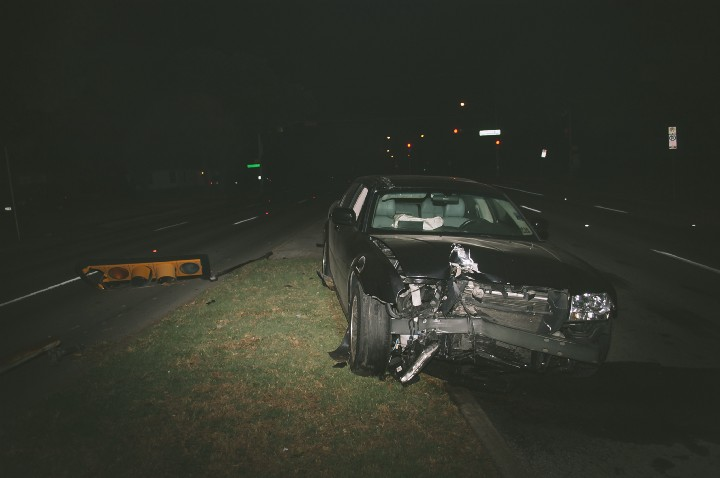




### Table of contents

-  importing libraries
-  loading dataset
-  EDA-General ( General visualization)
-  Data preprocessing
-  Key Insights


# Importing libraries

In [151]:
!pip install pyproj
!pip install missingno


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import missingno as msno
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from scipy.stats import normaltest, zscore
import pyarrow.parquet as pq
import pyarrow as pa
from scipy.stats import normaltest, zscore
import requests
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')

In [153]:
# pd.set_option('max_columns', None)
from mpl_toolkits.mplot3d import Axes3D

# loading dataset

In [154]:
from google.colab import drive
drive.mount('/content/drive')
accidents = pd.read_csv('/content/drive/MyDrive/data_eng/1995_Accidents_UK.csv',index_col='accident_reference')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

## Replace the Missing Indicators whith nan.

In [155]:
'''
  Replace all the missing indecators with nulls to help in visualize the data.
'''
def to_nan(df,replaced_values):
  df.replace(replaced_values,np.nan,inplace=True)
  return df

In [156]:
print("Nans percentage with missing inedcators")
accidents.isna().mean()*100

Nans percentage with missing inedcators


accident_index                                   0.000000
accident_year                                    0.000000
location_easting_osgr                            0.122319
location_northing_osgr                           0.122319
longitude                                      100.000000
latitude                                       100.000000
police_force                                     0.000000
accident_severity                                0.000000
number_of_vehicles                               0.000000
number_of_casualties                             0.000000
date                                             0.000000
day_of_week                                      0.000000
time                                             0.000000
local_authority_district                         0.000000
local_authority_ons_district                     0.000000
local_authority_highway                          0.000000
first_road_class                                 0.000000
first_road_num

In [157]:
replaced_values=['Unknown','-1','Data missing or out of range',-1,"unknown (self reported)"]
accidents_with_nan = to_nan(accidents, replaced_values)
print("Nans percentage with out missing inedcators")
accidents_with_nan.isna().mean()*100

Nans percentage with out missing inedcators


accident_index                                   0.000000
accident_year                                    0.000000
location_easting_osgr                            0.122319
location_northing_osgr                           0.122319
longitude                                      100.000000
latitude                                       100.000000
police_force                                     0.000000
accident_severity                                0.000000
number_of_vehicles                               0.000000
number_of_casualties                             0.000000
date                                             0.000000
day_of_week                                      0.000000
time                                             0.000000
local_authority_district                         0.000000
local_authority_ons_district                    11.624679
local_authority_highway                         12.135644
first_road_class                                 0.000000
first_road_num

## Visualize its missing values using a matrix plot.
In the matrix plot, each white line represents missing observations and the lines are visualized in the order they appear in the dataset, top to bottom. For large datasets like this, a cluster of missing values will form brighter white lines.

<Axes: >

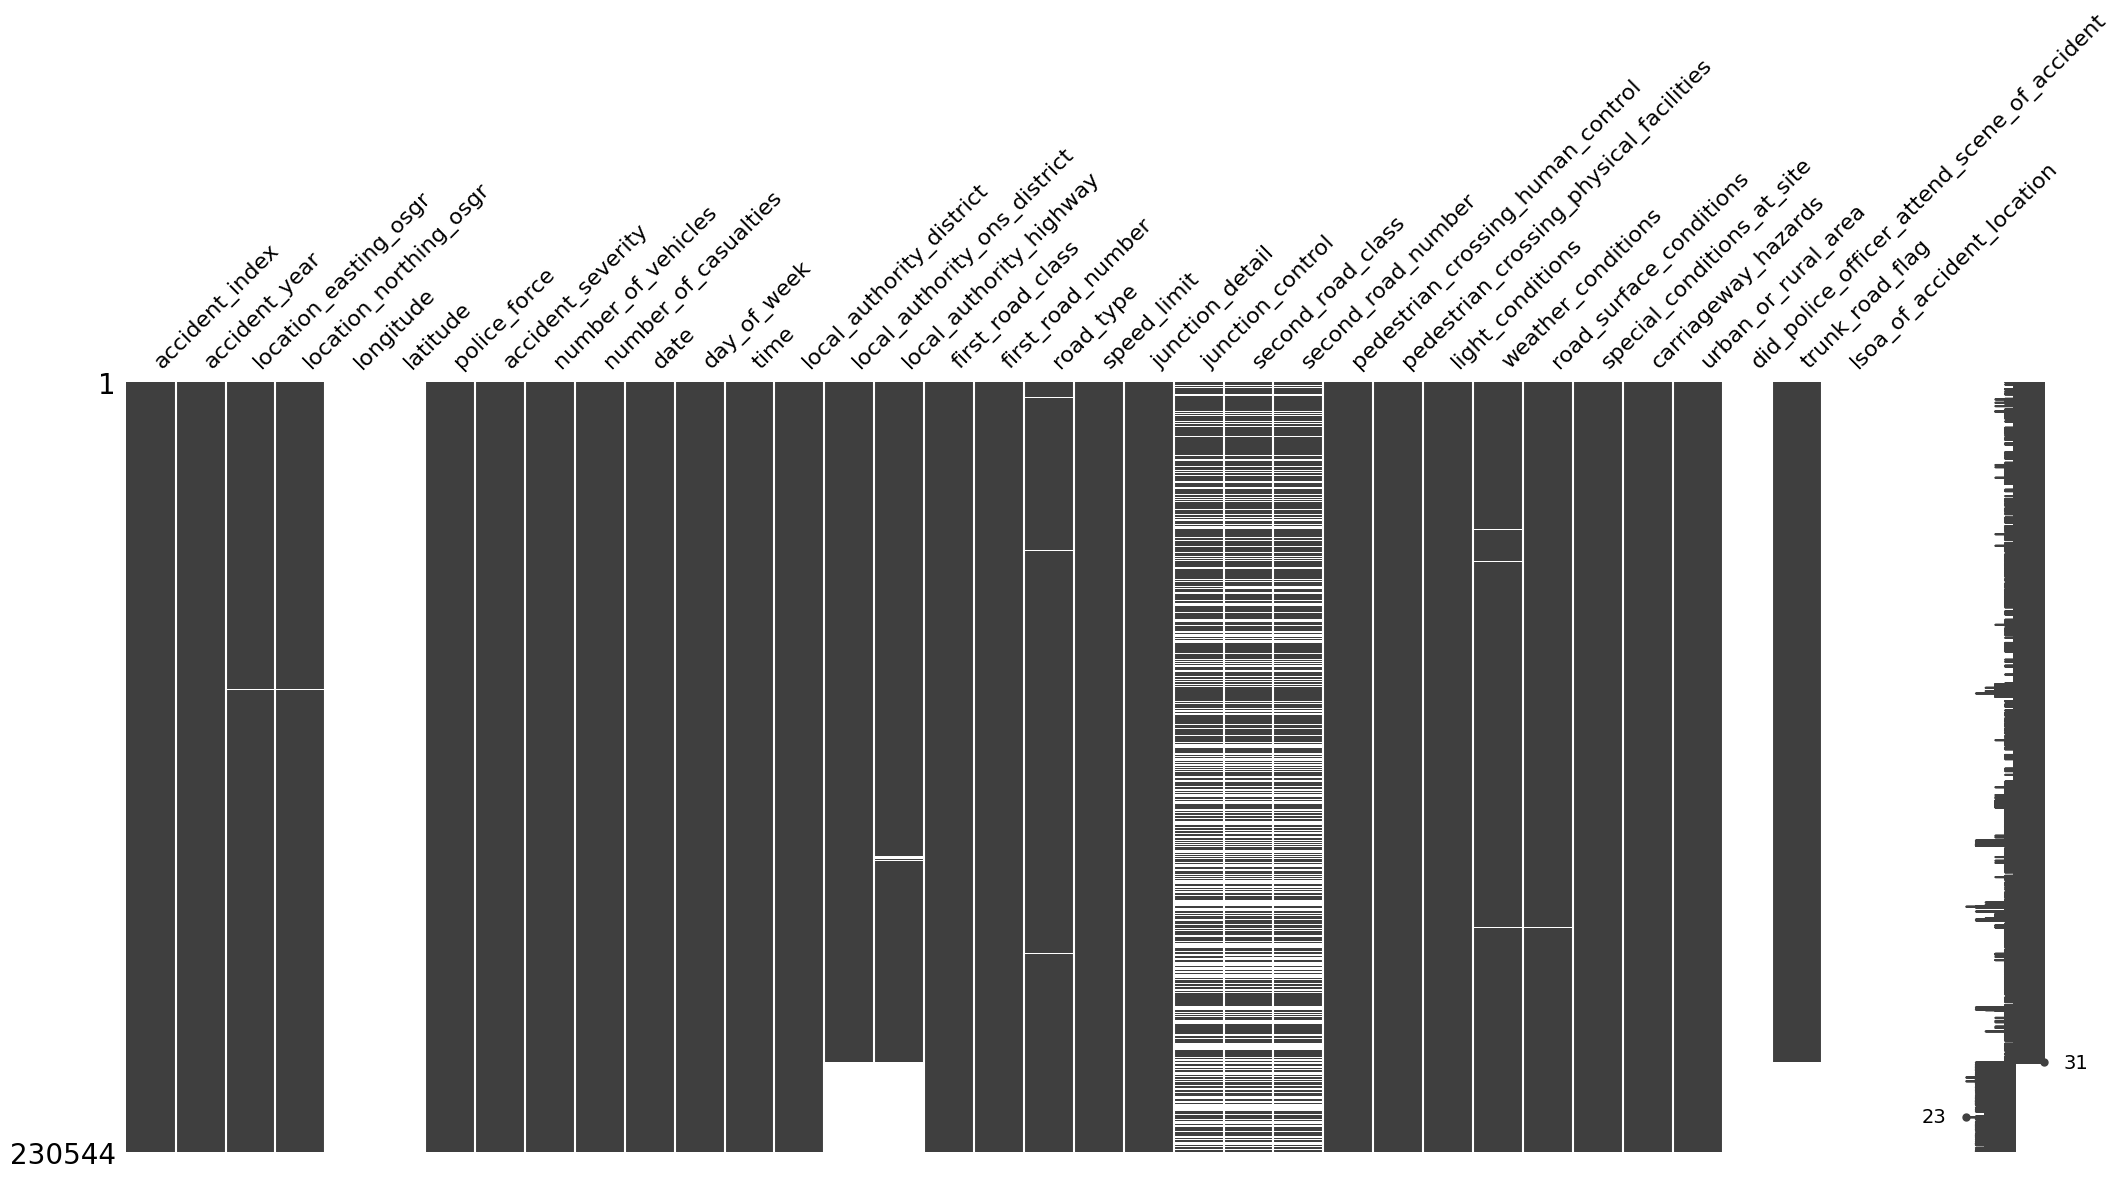

In [158]:
msno.matrix(accidents_with_nan)

## Remove duplicates.

In [159]:
'''
  Drop all duplicate rows.
'''
def drop_duplicate(df):
  df.drop_duplicates(keep=False, inplace=True)
  return df

### The shape of the dataframe before and after removing the duplicates.

In [160]:
print("Data shape before removing duplicates",accidents_with_nan.shape)
accidents_with_no_duplicates = drop_duplicate(accidents_with_nan.copy())
print("Data shape after removing duplicates",accidents_with_no_duplicates.shape)

Data shape before removing duplicates (230544, 35)
Data shape after removing duplicates (230544, 35)


## Change the types of the nuemrical features into float.

In [161]:
'''
  Get the numerical features and covert there type into numerical.
'''
def get_numerical_features(df, numerical_features_names):
  df[numerical_features_names] = df[numerical_features_names].astype(float)
  return df


In [162]:
numerical_features_names = ["location_easting_osgr","location_northing_osgr","longitude","latitude","number_of_vehicles","number_of_casualties","speed_limit"]
accidents_with_numerical_features = get_numerical_features(accidents_with_no_duplicates.copy(), numerical_features_names)
accidents_with_numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230544 entries, 010SA0586 to 984055995
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               230544 non-null  object 
 1   accident_year                                230544 non-null  int64  
 2   location_easting_osgr                        230262 non-null  float64
 3   location_northing_osgr                       230262 non-null  float64
 4   longitude                                    0 non-null       float64
 5   latitude                                     0 non-null       float64
 6   police_force                                 230544 non-null  object 
 7   accident_severity                            230544 non-null  object 
 8   number_of_vehicles                           230544 non-null  float64
 9   number_of_casualties                         230544 n

## Drop the unnecessary columns.


In [163]:
'''
  Drop all unnecessary columns that will which could have single value which will
  not add any information to the data as all entries have the same value
  or columns with number of nulls greater than certain threshold which will
  affect the calculations if we impute the missing or even all unique values
  columns which will also add no information.
'''
def drop_unnecessary_col(df,threshold):
  # drop columns with null percentage greater than certain threshold.
  null_precentage = df.isnull().mean()*100
  null_columns = list(null_precentage[null_precentage >= threshold].index)
  df.drop(null_columns,axis=1,inplace=True)
  # drop columns with only one single value (EX:- accident_year).
  single_value_columns = [column for column in df.columns if df[column].nunique() == 1]
  df.drop(single_value_columns,axis=1,inplace=True)
  # drop coulmns with unique value for each row (EX:- accident_index).
  unique_values_columns = [column for column in df.columns if df[column].nunique() == df.shape[0]]
  df.drop(unique_values_columns,axis=1,inplace=True)
  return df

In [164]:
print("Data shape before dropping unnecessary columns",accidents_with_numerical_features.shape)
accidents_with_necessary_features = drop_unnecessary_col(accidents_with_numerical_features.copy(),70)
print("Data shape after dropping unnecessary columns",accidents_with_necessary_features.shape)

Data shape before dropping unnecessary columns (230544, 35)
Data shape after dropping unnecessary columns (230544, 29)


### Visualize its missing values using a matrix plot.

<Axes: >

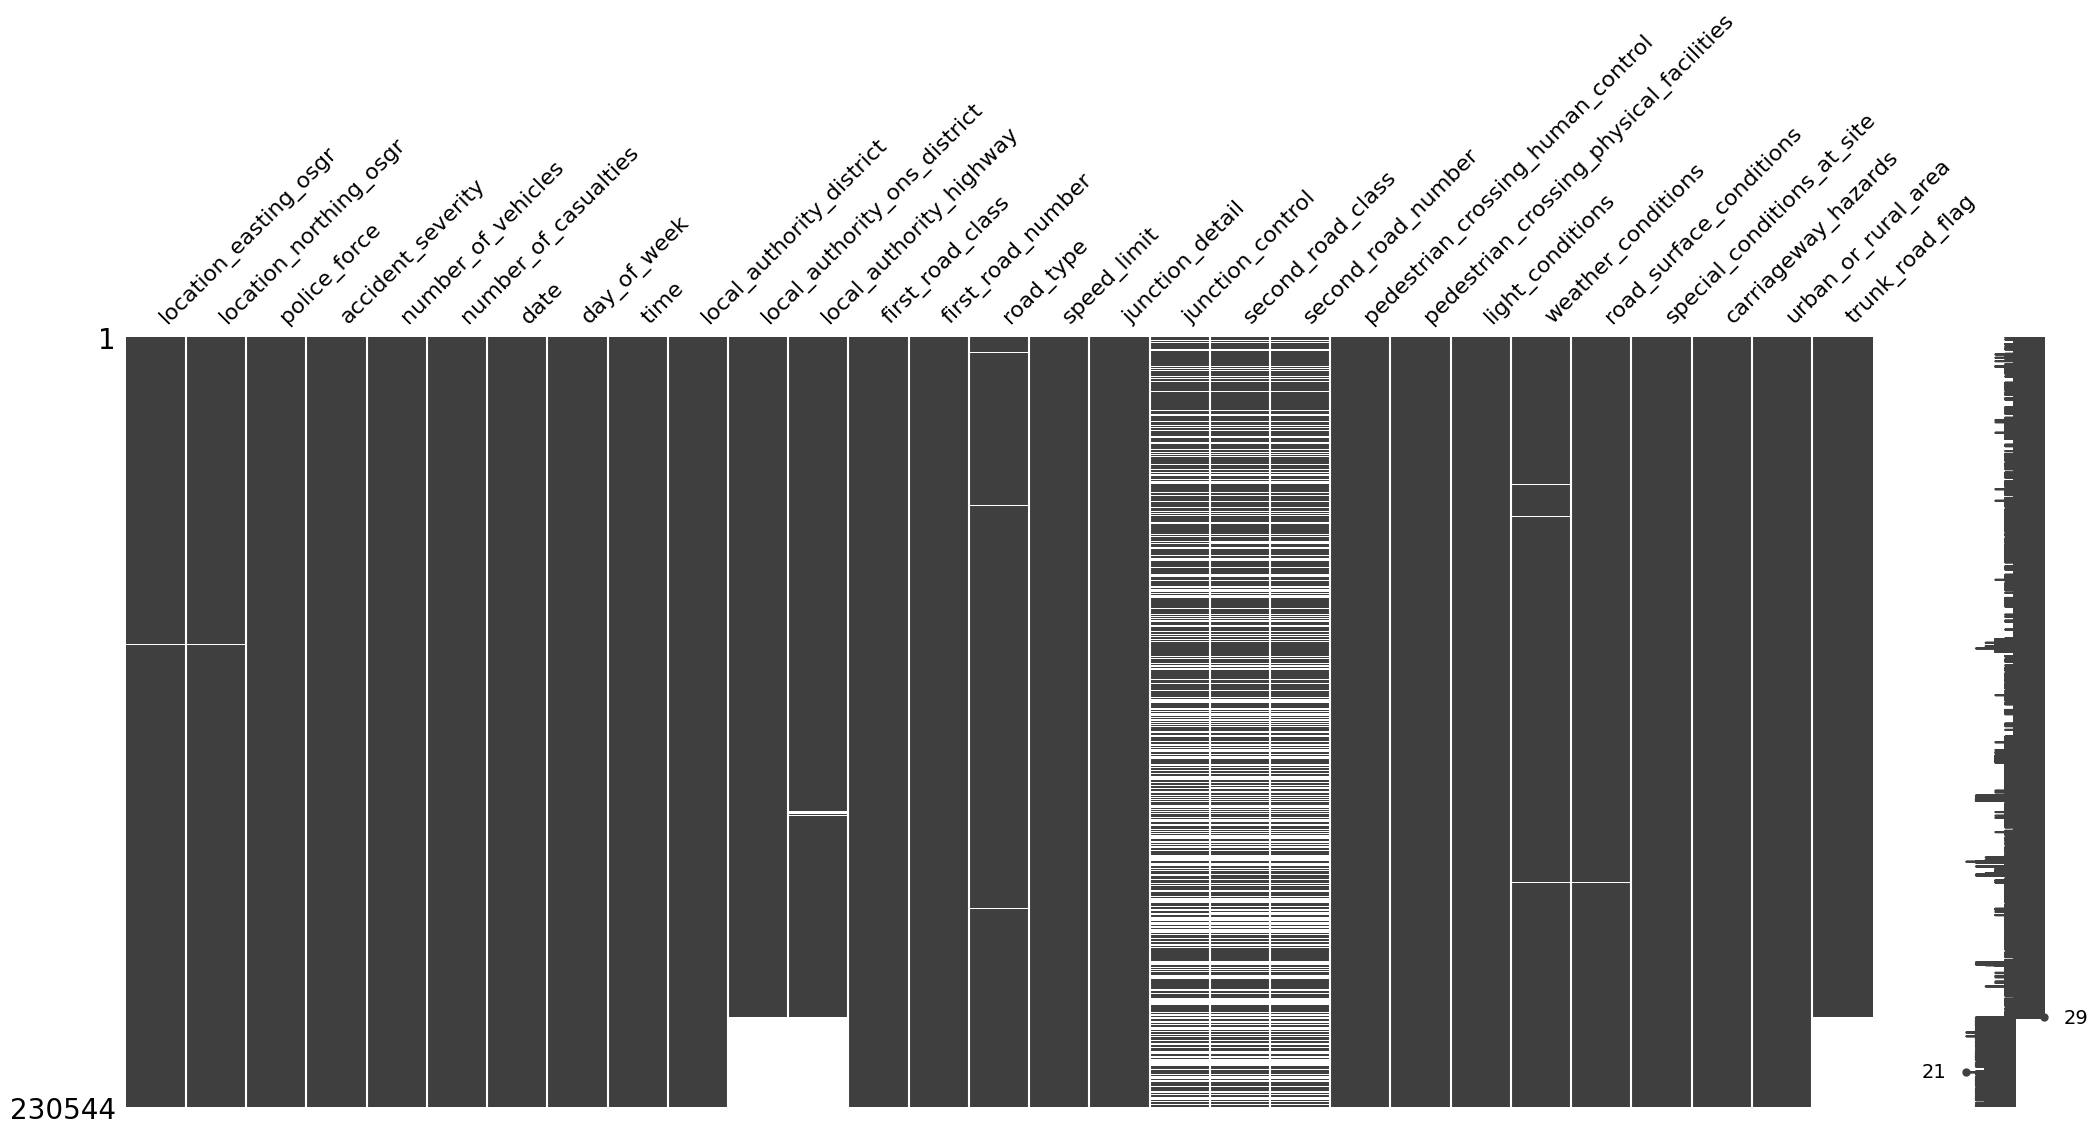

In [165]:
msno.matrix(accidents_with_necessary_features)

## Get the missing district name from the local authority district.

In [166]:
'''
  Get the missing district name from the local_authority_district,
  local_authority_ons_district, local_authority_highway as they all are the same
  and have more than thrshold (EX:- 50% which is not small percentage as they all
  not have the nulls at the same indices) identical values.
  Features meanings:
  - local_authority_district : Local authority in whose area the accident occurred.
  - local_authority_ons_district : The ONS district code of local authority in
    whose area the accident occurred.
  - local_authority_highway : Local authority responsible for the highway where
    the accident occurred.
'''
def find_district_names(df,threshold):
  # replace all the numerical values of nan as there is no numerical district name.
  df.local_authority_district = df.local_authority_district.where(df.local_authority_district.str.isalpha())
  # replace the nan values from local_authority_ons_district with the values from
  # local_authority_highway if there similarity is grater than the threshold.
  if (df.local_authority_ons_district == df.local_authority_highway).mean()*100 >= threshold:
    df.local_authority_ons_district = df.local_authority_ons_district.fillna(df.local_authority_highway)
  # replace the nan values from local_authority_ons_district with the values from
  # local_authority_district if there similarity is grater than the threshold.
  if (df.local_authority_ons_district == df.local_authority_district).mean()*100 >= threshold:
    df.local_authority_ons_district = df.local_authority_ons_district.fillna(df.local_authority_district)
  # drop local authority district and local authority highway as there is no need
  # for them and are considered redundant.
  df.drop(["local_authority_district","local_authority_highway"],axis = 1,inplace = True)
  return df

In [167]:
accidents_with_authority_district = find_district_names(accidents_with_necessary_features.copy(),50)

In [168]:
accidents_with_authority_district.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230544 entries, 010SA0586 to 984055995
Data columns (total 27 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   location_easting_osgr                    230262 non-null  float64
 1   location_northing_osgr                   230262 non-null  float64
 2   police_force                             230544 non-null  object 
 3   accident_severity                        230544 non-null  object 
 4   number_of_vehicles                       230544 non-null  float64
 5   number_of_casualties                     230544 non-null  float64
 6   date                                     230544 non-null  object 
 7   day_of_week                              230544 non-null  object 
 8   time                                     230544 non-null  object 
 9   local_authority_ons_district             203744 non-null  object 
 10  first_road_class          

### Visualize its missing values using a matrix plot.

<Axes: >

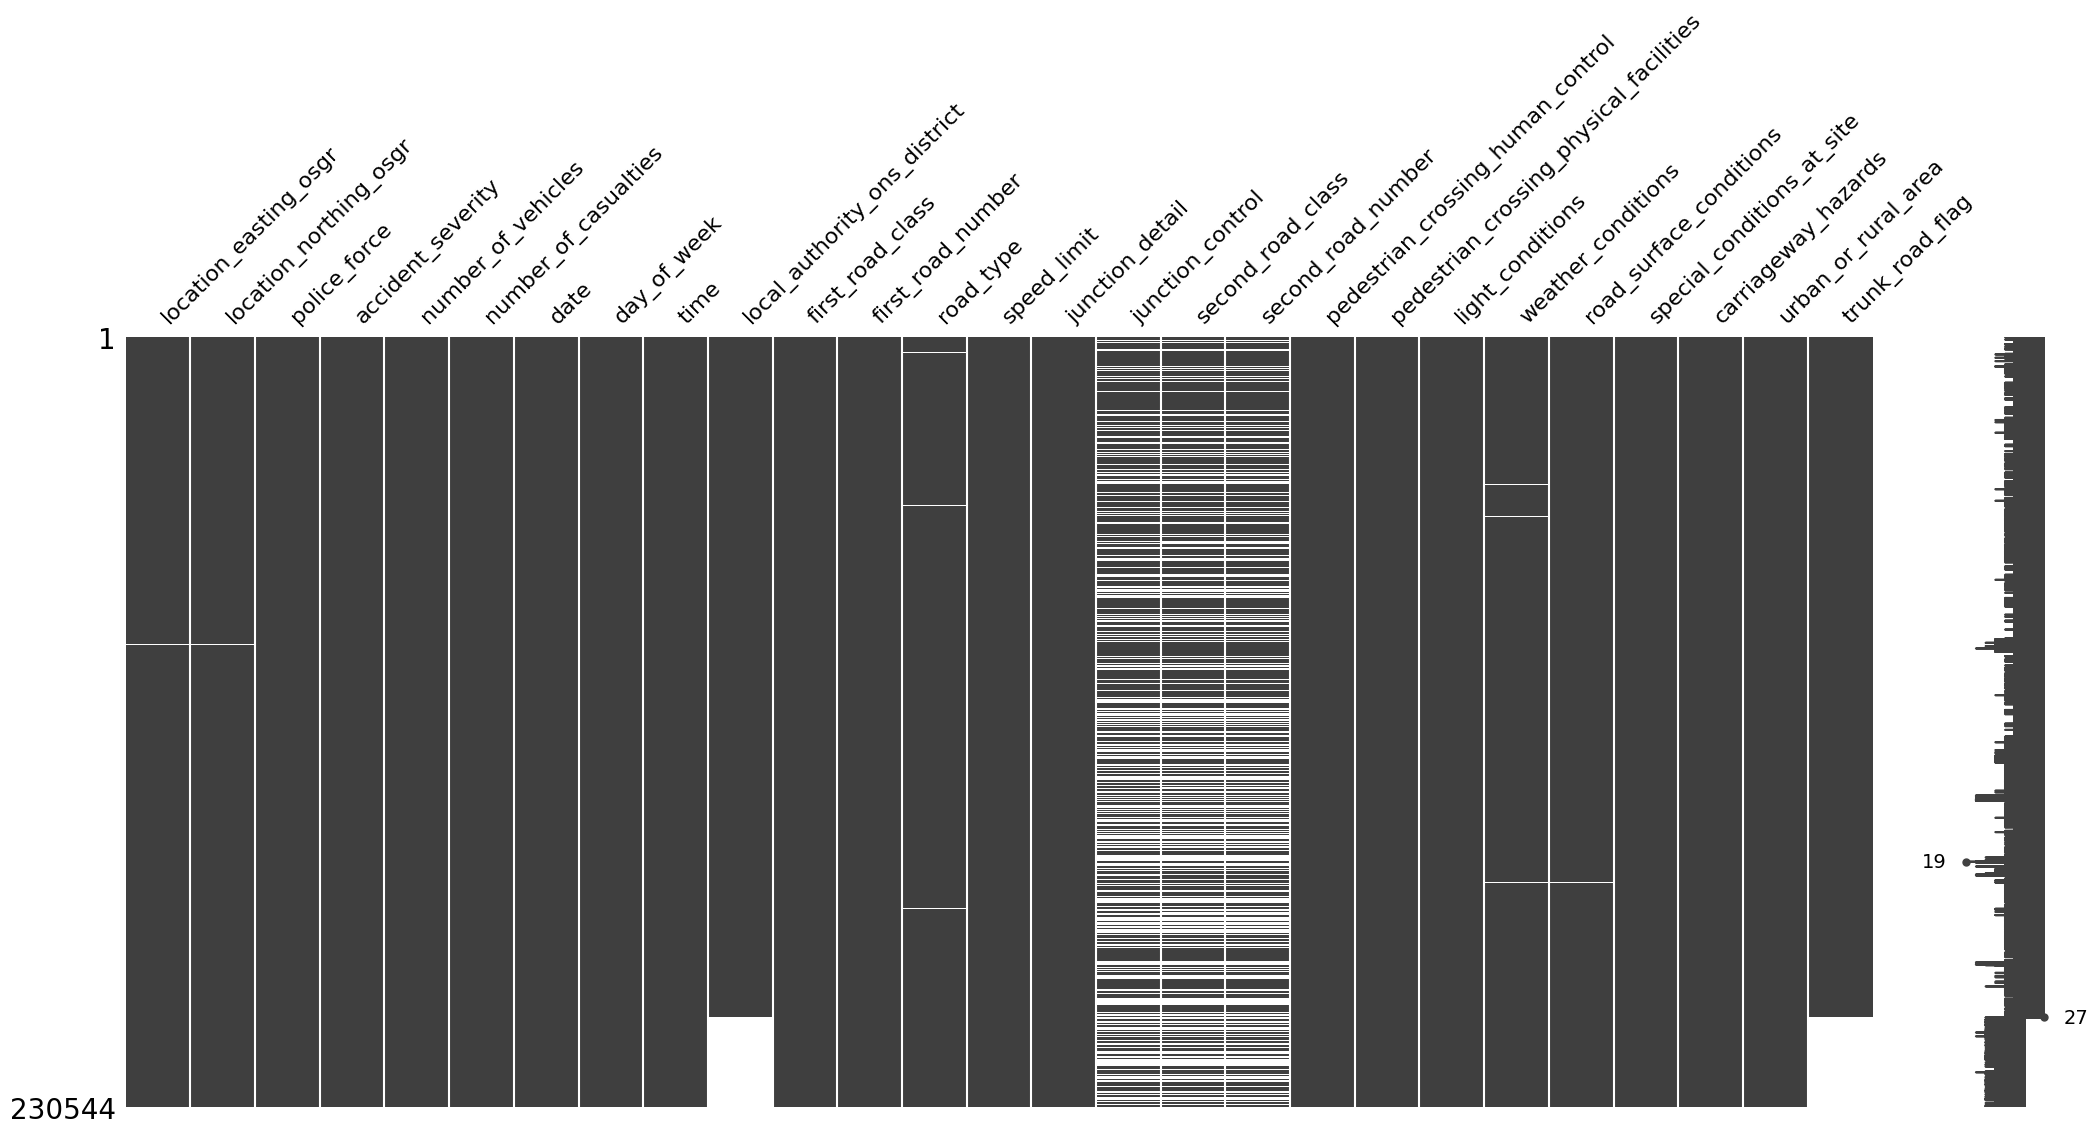

In [169]:
msno.matrix(accidents_with_authority_district)

## Fill the nan values from second road class and number and junction control.


In [170]:
'''
  Replace the nan values from second road class and number and junction control
  with (Not at junction or within 20 metres) for the accidents with no junction.
'''
def fill_missing_second_road_details(df):
  no_junction = "Not at junction or within 20 metres"
  df.loc[((df.junction_detail == no_junction) & (df.second_road_class.isna())),
         'second_road_class'] = no_junction
  df.loc[((df.junction_detail == no_junction) & (df.second_road_number.isna())),
         'second_road_number'] = no_junction
  df.loc[((df.junction_detail == no_junction) & (df.junction_control.isna())),
         'junction_control'] = no_junction
  return df

In [171]:
accidents_with_second_road = fill_missing_second_road_details(accidents_with_authority_district.copy())


In [172]:
print("The percentage of nan in second_road_class column before filling the nan is: ", accidents_with_authority_district.second_road_class.isna().mean()*100,"%")
print("The percentage of nan in junction_control column before filling the nan is: ", accidents_with_authority_district.junction_control.isna().mean()*100,"%")
print("The percentage of nan in second_road_number column before filling the nan is: ", accidents_with_authority_district.second_road_number.isna().mean()*100,"%")
accidents_with_second_road = fill_missing_second_road_details(accidents_with_authority_district.copy())
print("The percentage of nan in second_road_class column after filling the nan is: ", accidents_with_second_road.second_road_class.isna().mean()*100,"%")
print("The percentage of nan in junction_control column after filling the nan is: ", accidents_with_second_road.junction_control.isna().mean()*100,"%")
print("The percentage of nan in second_road_number column after filling the nan is: ", accidents_with_second_road.second_road_number.isna().mean()*100,"%")


The percentage of nan in second_road_class column before filling the nan is:  38.15280380317857 %
The percentage of nan in junction_control column before filling the nan is:  37.69519050593379 %
The percentage of nan in second_road_number column before filling the nan is:  38.15367131653827 %
The percentage of nan in second_road_class column after filling the nan is:  0.5474009299743215 %
The percentage of nan in junction_control column after filling the nan is:  0.14140467763203554 %
The percentage of nan in second_road_number column after filling the nan is:  0.5482684433340274 %


### Visualize its missing values using a matrix plot.

<Axes: >

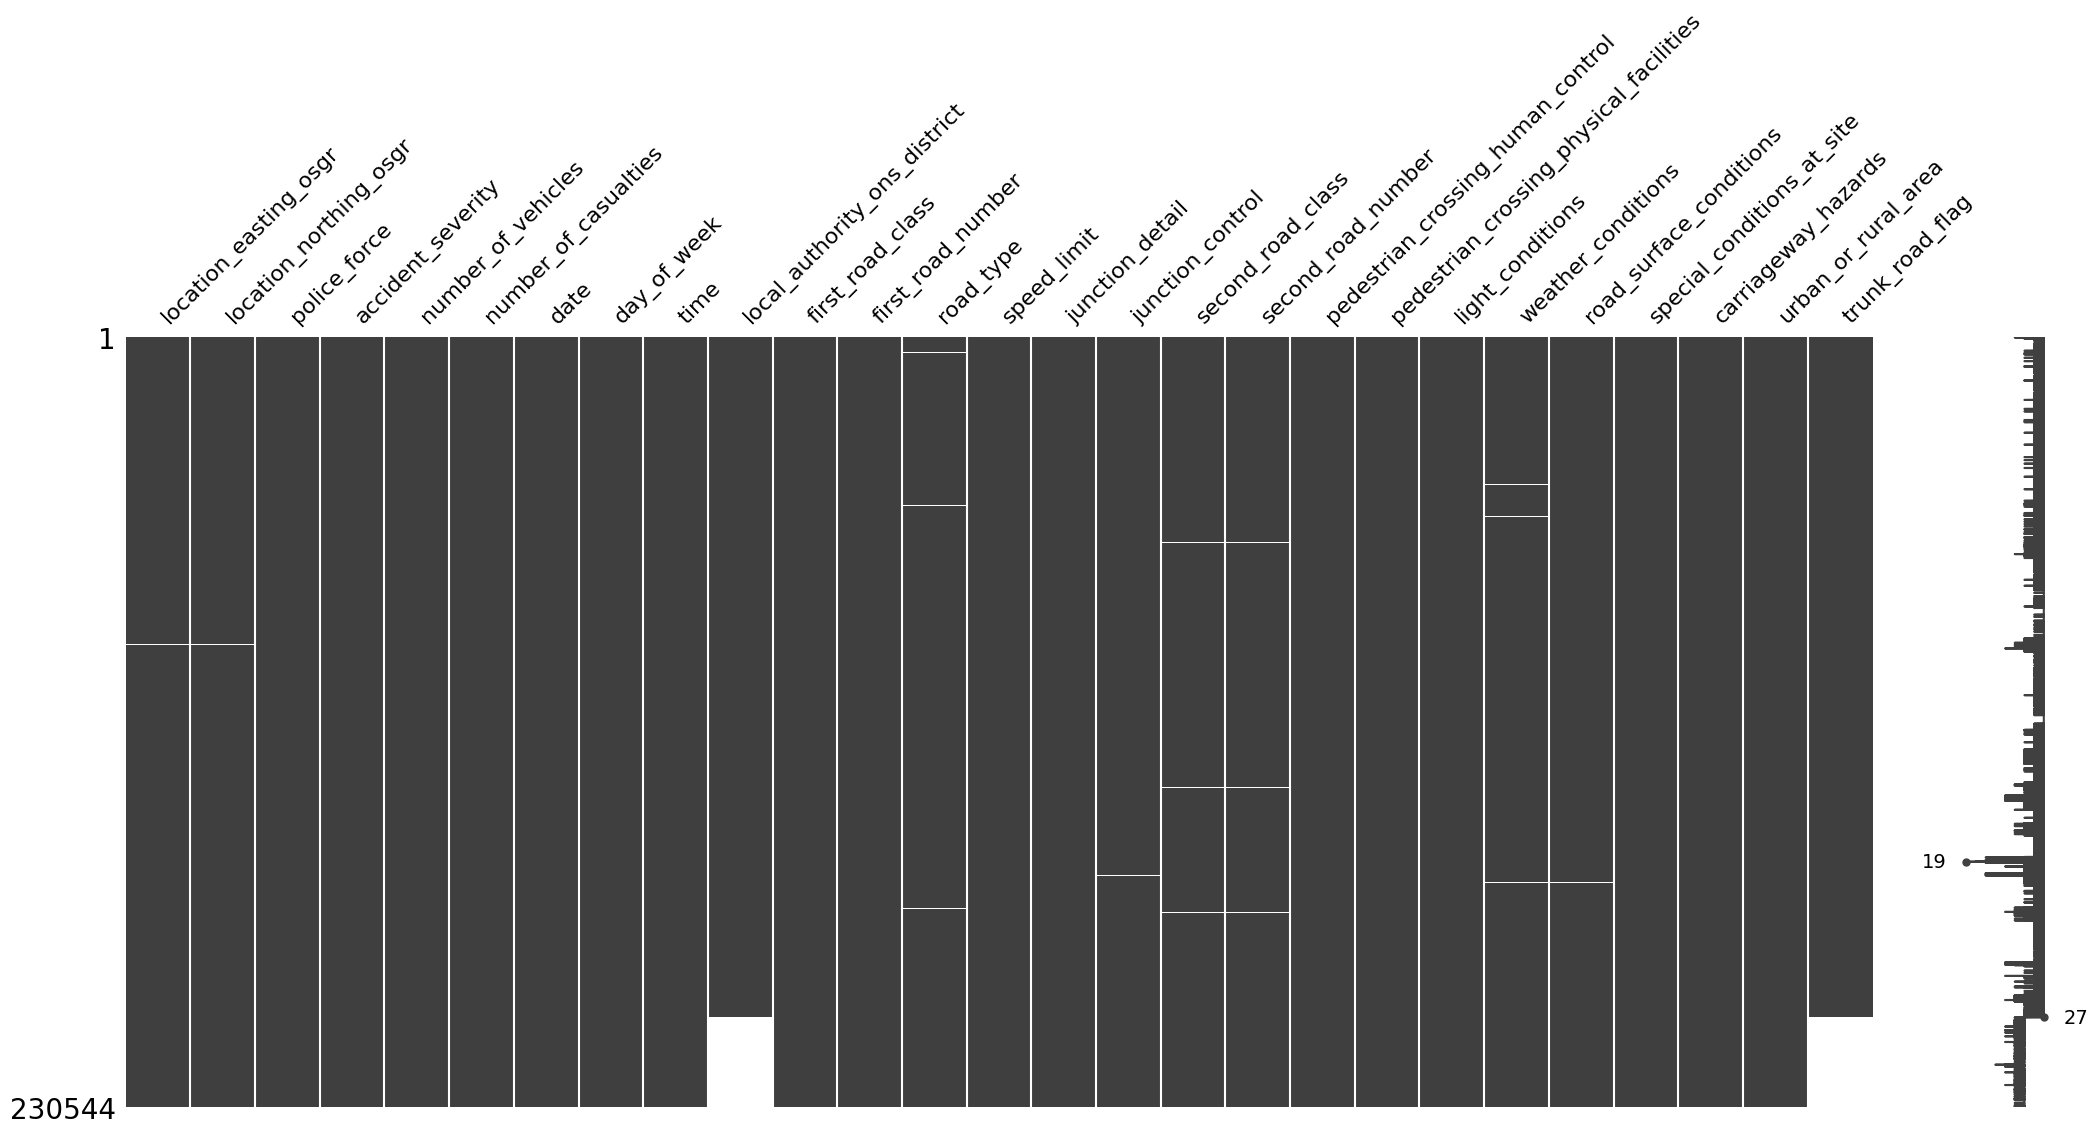

In [173]:
msno.matrix(accidents_with_second_road)

## Impute the missing data.

In [174]:
'''
  Impute the missing data depending on the missing type and percentage.
'''
def handel_missing_data(df):
  # msno.matrix(df)
  # drop all the none in the column if there percentage is less than 1% which are MCAR.
  less_than_1_percent_columns = df.columns[(df.isna().mean()*100 < 1)&(df.isna().mean()*100 > 0)]
  if (len(less_than_1_percent_columns) > 0):
    df.dropna(subset = less_than_1_percent_columns, inplace=True)
    print(less_than_1_percent_columns.tolist(),"are missing completely at random.")
  # impute all the none in the column if there percentage is less than 5% MAR.
  less_than_5_percent_columns = df.columns[(df.isna().mean()*100 < 5)&(df.isna().mean()*100 > 1)]
  if (len(less_than_5_percent_columns) > 0):
    less_than_5_percent_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    less_than_5_percent_imputer.fit(df[less_than_5_percent_columns])
    df[less_than_5_percent_columns] = less_than_5_percent_imputer.transform(df[less_than_5_percent_columns])
    print(less_than_5_percent_columns.tolist(),"are missing at random.")
  # impute all the none in the column if there percentage is less than 20% using missing indecator MNAR.
  less_than_20_percent_columns = df.columns[(df.isna().mean()*100 < 20)&(df.isna().mean()*100 > 5)]
  if (len(less_than_20_percent_columns) > 0):
      df[less_than_20_percent_columns.tolist()] = df[less_than_20_percent_columns.tolist()].fillna("Data missing or out of range")
      print(less_than_20_percent_columns.tolist(),"are missing not at random.")
  return df,less_than_20_percent_columns.tolist()

In [175]:
print("Data shape before handel missing data",accidents_with_second_road.shape)
accidents_with_imputation, MNAR_columns = handel_missing_data(accidents_with_second_road.copy())
print("Data shape after handel missing data",accidents_with_imputation.shape)

Data shape before handel missing data (230544, 27)
['location_easting_osgr', 'location_northing_osgr', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards'] are missing completely at random.
['local_authority_ons_district', 'trunk_road_flag'] are missing not at random.
Data shape after handel missing data (225140, 27)


### The missing data in local_authority_ons_district
their is a relation between the missing districts at local_authority_ons_district and the police_force as there are some police_forces with all local_authority_ons_district equal null.

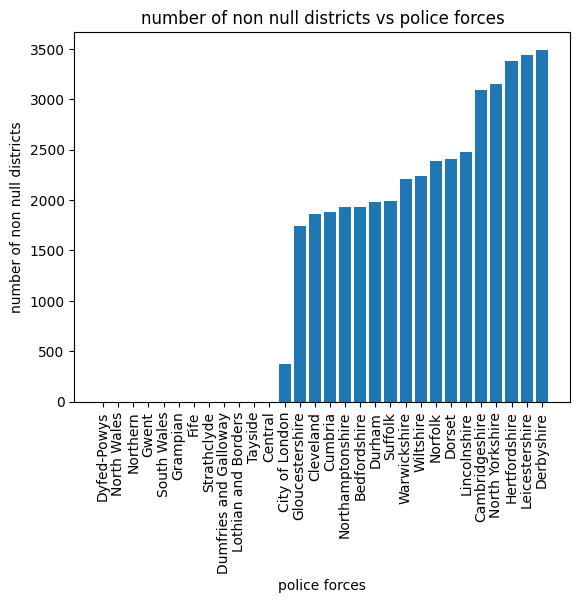

In [176]:
df = accidents_with_imputation.copy()
df["local_authority_ons_district_not_missing"] = df.local_authority_ons_district != "Data missing or out of range";
df = df[["police_force","local_authority_ons_district_not_missing"]].groupby("police_force").sum().sort_values("local_authority_ons_district_not_missing").iloc[:30]
plt.bar(df.index,df.local_authority_ons_district_not_missing)
plt.xticks(label = df.local_authority_ons_district_not_missing, rotation='vertical')
plt.ylabel("number of non null districts")
plt.xlabel("police forces")
plt.title("number of non null districts vs police forces")
plt.show();

### The missing data in trunk_road_flag
their is a relation between the missing road trunks at trunk_road_flag and the police_force as there are some police_forces with all trunk_road_flag equal null.

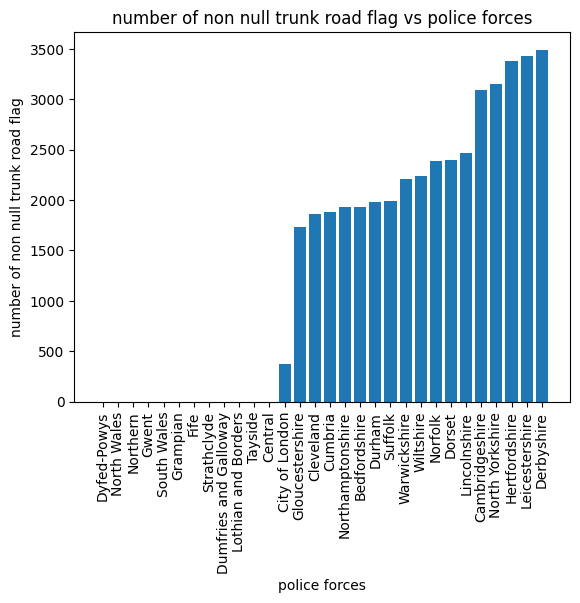

In [177]:
df = accidents_with_imputation.copy()
df["trunk_road_flag_not_missing"] = df.trunk_road_flag != "Data missing or out of range";
df = df[["police_force","trunk_road_flag_not_missing"]].groupby("police_force").sum().sort_values("trunk_road_flag_not_missing").iloc[:30]
plt.bar(df.index,df.trunk_road_flag_not_missing)
plt.xticks(label = df.trunk_road_flag_not_missing, rotation='vertical')
plt.ylabel("number of non null trunk road flag")
plt.xlabel("police forces")
plt.title("number of non null trunk road flag vs police forces")
plt.show();

### Visualize its missing values using a matrix plot.

<Axes: >

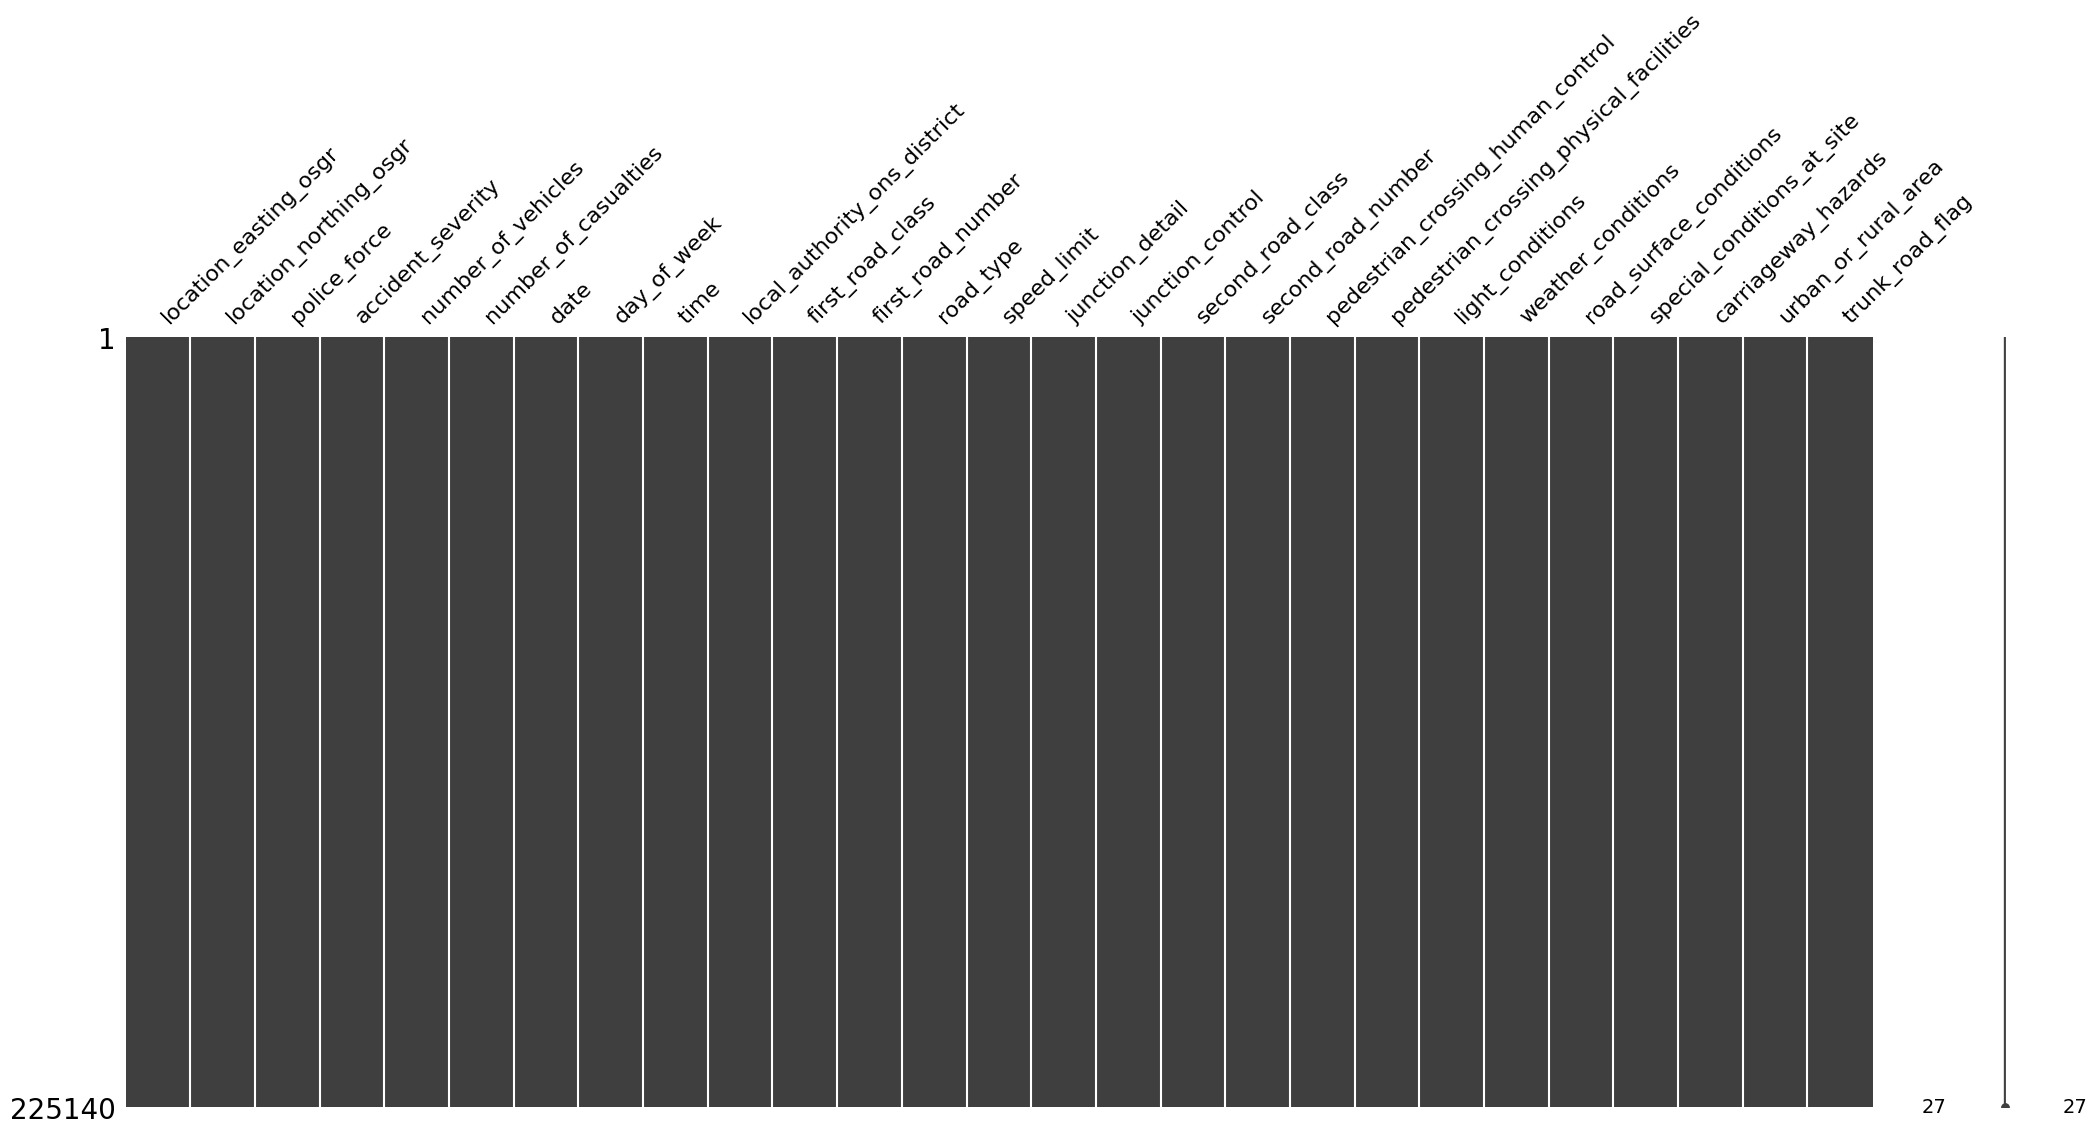

In [178]:
msno.matrix(accidents_with_imputation)

## Get all date related features

In [179]:
'''
  Divide the day into parts.
'''
def get_dayg_part(hour):
    if hour >= 6 and hour < 10:
        return 1
    elif hour >= 10 and hour < 12:
        return 2
    elif hour >= 12 and hour < 14:
        return 3
    elif hour >= 14 and hour < 16:
        return 4
    elif hour >= 16 and hour < 18:
        return 5
    elif hour >= 18 and hour < 22:
        return 6
    else:
        return 7
'''
  Divide the year into seasons.
'''
def get_season(month):
  if (month == 12 or month == 1 or month == 2):
      return 1
  elif(month == 3 or month == 4 or month == 5):
      return 2
  elif(month == 6 or month== 7 or month == 8):
      return 3
  else:
      return 4
'''
  Get all date related features (minute, hour, day, week, month, season,
  time_of_week, weekend) from the date and the time features as they were
  categorical.
'''
def date_manipulation(df):
  #convert type of date column to datetime
  df['date'] = pd.to_datetime(df['date'])

  #creating minute, hour, day, week, month.
  df['minute'] = df['time'].str[3:5]
  df['hour'] = df['time'].str[0:2]
  df['day'] = df['date'].dt.day
  df['Week'] = df['date'].dt.isocalendar().week
  df['month'] = df['date'].dt.month

  #creating season column
  df['season'] = df['month'].apply(get_season)

  #creating weekend column; 1 represents weekend, 0 represents weekday
  df['weekend'] = np.where(df['day_of_week'].isin(['Saturday', 'Sunday']), 1, 0)

  # convert label encoding to numeric

  days_of_week = {
    "Sunday" : 1,
    "Monday" : 2,
    "Tuesday" : 3,
    "Wednesday" : 4,
    "Thursday" : 5,
    "Friday" : 6,
    "Saturday" : 7
    }
  df["day_of_week"] = df["day_of_week"].replace(days_of_week)
  df["day_of_week"] = pd.to_numeric(df["day_of_week"])

  #convert hour and minute to integer
  df['hour'] =  pd.to_numeric(df['hour'])
  df['hour'] = df['hour'].astype('int')
  df['minute'] =  pd.to_numeric(df['minute'])
  df['minute'] = df['minute'].astype('int')

  #spicify the time of date
  df['time_of_day']= df['hour'].apply(get_dayg_part)

  # drop the date and the time
  df.drop(['date','time'],axis=1,inplace=True)

  return df

In [180]:
# numerical columns names before date manipulation.
numerical_columns_names = accidents_with_imputation.select_dtypes(exclude = object).columns.tolist()
print("Data shape before adding date columns and date manipulation",accidents_with_imputation.shape)
accidents_after_date_manipulation = date_manipulation(accidents_with_imputation.copy())
print("Data shape after adding date columns and date manipulation",accidents_after_date_manipulation.shape)
# numerical columns names after date manipulation.
new_numerical_columns_names = accidents_after_date_manipulation.select_dtypes(exclude = object).columns.tolist()
accidents_after_date_manipulation.head()
accidents_after_date_manipulation.isnull().sum()

Data shape before adding date columns and date manipulation (225140, 27)
Data shape after adding date columns and date manipulation (225140, 33)


location_easting_osgr                      0
location_northing_osgr                     0
police_force                               0
accident_severity                          0
number_of_vehicles                         0
number_of_casualties                       0
day_of_week                                0
local_authority_ons_district               0
first_road_class                           0
first_road_number                          0
road_type                                  0
speed_limit                                0
junction_detail                            0
junction_control                           0
second_road_class                          0
second_road_number                         0
pedestrian_crossing_human_control          0
pedestrian_crossing_physical_facilities    0
light_conditions                           0
weather_conditions                         0
road_surface_conditions                    0
special_conditions_at_site                 0
carriagewa

In [181]:
accidents_after_date_manipulation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225140 entries, 010SA0586 to 984055995
Data columns (total 33 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   location_easting_osgr                    225140 non-null  float64
 1   location_northing_osgr                   225140 non-null  float64
 2   police_force                             225140 non-null  object 
 3   accident_severity                        225140 non-null  object 
 4   number_of_vehicles                       225140 non-null  float64
 5   number_of_casualties                     225140 non-null  float64
 6   day_of_week                              225140 non-null  int64  
 7   local_authority_ons_district             225140 non-null  object 
 8   first_road_class                         225140 non-null  object 
 9   first_road_number                        225140 non-null  object 
 10  road_type                 

In [182]:
accidents_after_date_manipulation.drop(axis=1,columns=["second_road_number","first_road_number"],inplace=True)

## Encode the categorical features.

In [183]:
'''
  The threshold is calculated as the percentage of the rare values is less than the percentage of the most two frequent values.
'''
def get_threshold(col):
  col_val_percent = (col.value_counts(normalize=True))
  max_freq = col_val_percent.iloc[0] + col_val_percent.iloc[1] + col_val_percent.iloc[2]
  df = col_val_percent.sort_values(ascending=True).rename_axis('col_val').reset_index(name = 'percentage')
  df['CUMSUM'] = df['percentage'].cumsum()
  threshold = df[df['CUMSUM'] < max_freq]['percentage'].iloc[-1]
  return threshold
'''
  Encode all the values that have frequency greater than the threshold will be
  encoded and the other features will be mapped to other and encoded as one entry.
'''
def OHE_with_threshold(col, threshold = None):
    dummy_col = pd.get_dummies(data = col, columns = [col.name])
    if (threshold == None):
      threshold = get_threshold(col)
      # print(col,threshold)
    freq = pd.value_counts(col, sort=False, normalize=True) < threshold
    if freq.sum() == 0:
        return dummy_col
    else:
        encoding_output = dummy_col.loc[:, ~freq].join(dummy_col.loc[:, freq].sum(1).rename('other'))
        encoding_output = encoding_output.add_prefix(col.name + "_")
        return encoding_output

'''
  Encode the categorical features into numerical ones depending on the feature type.
  - ordinal features: will be encoded using label encoding as we can
  give some features priority over others.
  - nominal features: will be encoded using one-hot encoding with some modifications.
    - nominal with high cardinality:  merge all the rare values into one category
     and encoded them as one feature using one hot encoding also we drop the most
     frequent category in each feature to be encoded as all zeros to save one column.
    - nominal with low cardinality: encode using one hot encoding also we drop
    the most frequent category in each feature to be encoded as all zeros to save
     one column.
    - second_road_number or first_road_number columns:
'''
def encode_cat_col(df):
  cat_cols = df.select_dtypes(include=['object']).columns.tolist()
  # loop over all the categorical features to encode them.
  for column in cat_cols:
    # calculate the cardinality of each categorical feature.
    cardinality = df[column].nunique()
    if (column == "accident_severity"):  # ordinal feature
      df["accident_severity"] = df["accident_severity"].replace({'Fatal':2,'Serious':1,'Slight':0})
    elif (column == "light_conditions"):   # ordinal feature
      # Encoding Light Conditions(0 = Light, 1 = Medium, 2 = Dark)
      df["light_conditions"].replace("Daylight", 0, inplace=True)
      df["light_conditions"].replace("Darkness - lights lit", 1, inplace=True)
      df["light_conditions"].replace("Darkness - no lighting", 2, inplace=True)
      df["light_conditions"].replace("Darkness - lights unlit", 2, inplace=True)
      df["light_conditions"].replace("Darkness - lighting unknown", 2, inplace=True)
    # nominal features
    elif (cardinality >= 20): # nominal with high cardinality
      encoding_output = OHE_with_threshold(df[column],0.01)
      # drop the most frequent column.
      most_frequent_column_name = encoding_output.sum().sort_values().index[-1]
      encoding_output.drop([most_frequent_column_name], axis = 1, inplace = True)
      # drop the orginal column.
      df.drop([column], axis = 1, inplace = True)
      df = df.join(encoding_output)
    else:
      # creating instance of one-hot-encoder
      onehot_encoder = OneHotEncoder(handle_unknown='ignore',)
      encoding_output = onehot_encoder.fit_transform(df[[column]])
      columns_name = onehot_encoder.get_feature_names_out([column])
      one_hot_encoded_frame = pd.DataFrame.sparse.from_spmatrix(encoding_output, columns=columns_name)
      # drop the most frequent column.
      most_frequent_column_name = df[column].value_counts().sort_values().index[-1]
      one_hot_encoded_frame.drop([column+"_"+most_frequent_column_name], axis = 1, inplace = True)
      one_hot_encoded_frame.index = df.index
      # drop the orginal column.
      df.drop([column], axis = 1, inplace = True)
      df = df.join(one_hot_encoded_frame)
  return df

In [184]:
print("Data shape before encoding the categrical features",accidents_after_date_manipulation.shape)
accidents_after_encoding = encode_cat_col(accidents_after_date_manipulation.copy())
print("Data shape after encoding the categrical features",accidents_after_encoding.shape)
accidents_after_encoding.head()

Data shape before encoding the categrical features (225140, 31)
Data shape after encoding the categrical features (225140, 113)


,location_easting_osgr,location_northing_osgr,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,speed_limit,light_conditions,minute,hour,...,special_conditions_at_site_Roadworks,carriageway_hazards_Dog on road,carriageway_hazards_Other animal on road,carriageway_hazards_Other object on road,carriageway_hazards_Previous accident,carriageway_hazards_Vehicle load on road,urban_or_rural_area_Rural,urban_or_rural_area_Unallocated,trunk_road_flag_Data missing or out of range,trunk_road_flag_Trunk (Roads managed by Highways England)
accident_reference,,,,,,,,,,,,,,,,,,,,,
010SA0586,530180.0,200560.0,1,1.0,1.0,7,70.0,0,45,14,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
010SU0956,519980.0,202940.0,1,3.0,3.0,6,70.0,0,49,8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
010SU0957,519420.0,203280.0,2,8.0,3.0,4,70.0,2,0,20,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
010SU0958,522780.0,199980.0,0,3.0,1.0,6,70.0,1,30,18,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
010SU0959,522110.0,200520.0,0,5.0,1.0,6,70.0,1,36,16,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Outliers

In [185]:
'''
  Remove outliers using zscore with normal distribution with threshold (EX:- 3).
'''
def get_zscore(df, col, threshold):
  z = np.abs(zscore(df[col]))
  filtered_entries = z < threshold
  filtered_df = df[filtered_entries]
  return filtered_df
'''
  Remove outliers using IQR with non-normal distribution with threshold (EX:- 1.5).
'''
def get_IQR(df, col, threshold):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  cut_off = IQR * threshold
  lower = Q1 - cut_off
  upper =  Q3 + cut_off
  filtered_df = df[(df[col] < upper)&(df[col] > lower)]
  if IQR == 0:
    return df,IQR
  return filtered_df, IQR

'''
  Outliers Exploration using BoxPlot, ViolinPlot, HistPlot, and KdePlot.
'''
def outliers_plot(df, col, state):
  fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=100)
  #create chart in each subplot
  fig.suptitle(col + " " + state + " removing the outliers")
  sns.boxplot(data=df, x=col, ax=axes[0])
  sns.violinplot(data=df, x=col, ax=axes[1])
  sns.histplot(data=df[col], ax=axes[2], bins=30)
  axes[2].set_yscale('log')
  sns.kdeplot(data=df[col], ax=axes[3])
  # axes[3].set_yscale('log')

'''
  Remove the outliers from the numerical features using zscore or IQR depending on the
  distribution of the data which can be checked using normaltest that test whether
  a sample differs from a normal distribution.
  This function tests the null hypothesis that a sample comes from a normal
  distribution. It is based on D’Agostino and Pearson’s [1], [2] test that combines
  skew and kurtosis to produce an omnibus test of normality.
  This method return A 2-sided chi squared probability p for the hypothesis test.
  If p > 0.05 then the distribution is normal otherwise the distribution is not
  normal.
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

'''
def remove_outliers (df, numerical_columns_names):
  spatial_data = ['location_easting_osgr','location_northing_osgr','longitude','latitude']
  filtered_df = df.copy()
  for col in numerical_columns_names:
    if (col not in spatial_data):
      stat , p = normaltest(filtered_df[col])
      outliers_plot(filtered_df, col, "before")
      if p > 0.05:
        print(col,':','probably normal dist')
        print(filtered_df.shape,col,"before removing the outlier")
        filtered_df = get_zscore(filtered_df, col, 3)
        print(filtered_df.shape,col,"after removing the outlier")
      else:
        # if IQR = zero >> zscore, else >> IQR
        print(col,':','probably  not normal dist')
        print(filtered_df.shape,col,"before removing the outlier")
        filtered_df, IQR = get_IQR(filtered_df, col, 1.5)
        print(filtered_df.shape,col,"after removing the outlier")
        # which means that most of the values of the features have the same value
        # and the Q1 and Q2 are the same.
        if IQR == 0:
          print("IQR == 0 so we used zscoe")
          print(filtered_df.shape,col,"before removing the outlier")
          filtered_df = get_zscore(filtered_df, col, 3)
          print(filtered_df.shape,col,"after removing the outlier")
      outliers_plot(filtered_df, col, "after")
  return filtered_df

Data shape before removing the outliers (225140, 113)
number_of_vehicles : probably  not normal dist
(225140, 113) number_of_vehicles before removing the outlier
(220444, 113) number_of_vehicles after removing the outlier
number_of_casualties : probably  not normal dist
(220444, 113) number_of_casualties before removing the outlier
(220444, 113) number_of_casualties after removing the outlier
IQR == 0 so we used zscoe
(220444, 113) number_of_casualties before removing the outlier
(214814, 113) number_of_casualties after removing the outlier
speed_limit : probably  not normal dist
(214814, 113) speed_limit before removing the outlier
(214811, 113) speed_limit after removing the outlier
Data shape after removing the outliers (214811, 113)


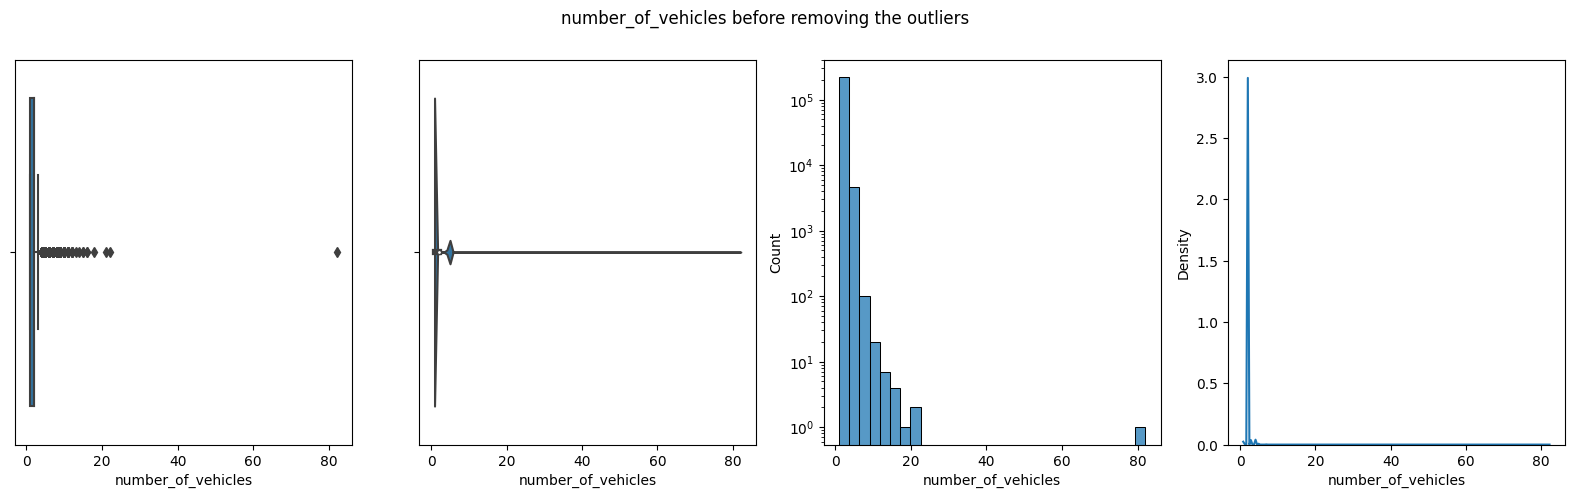

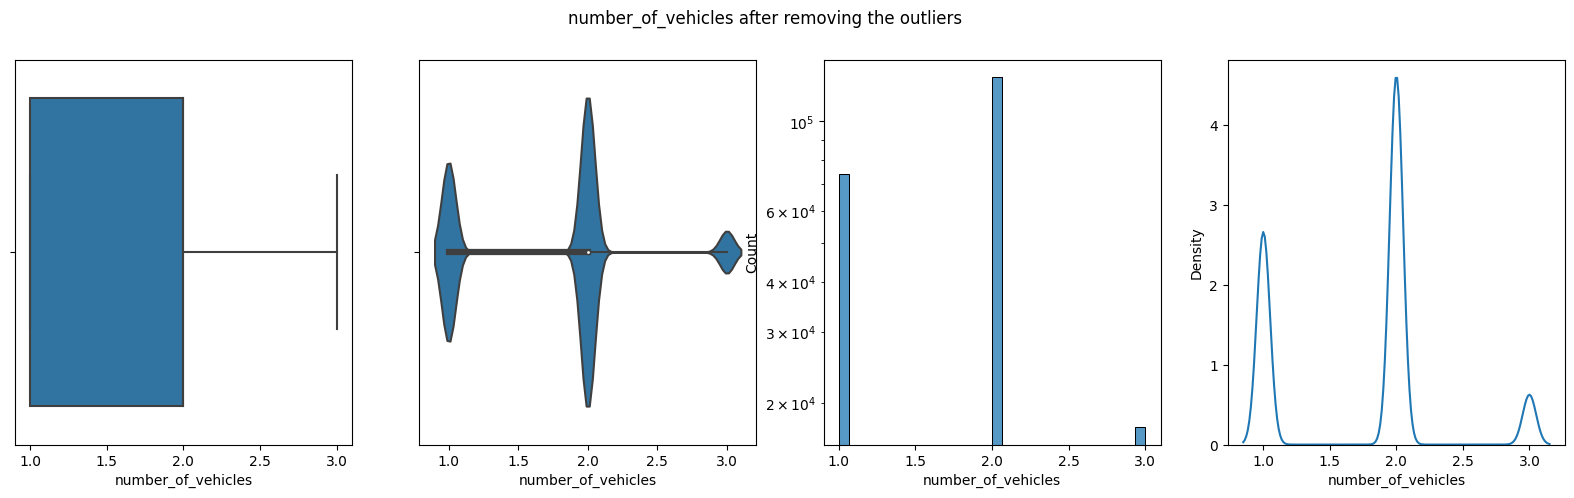

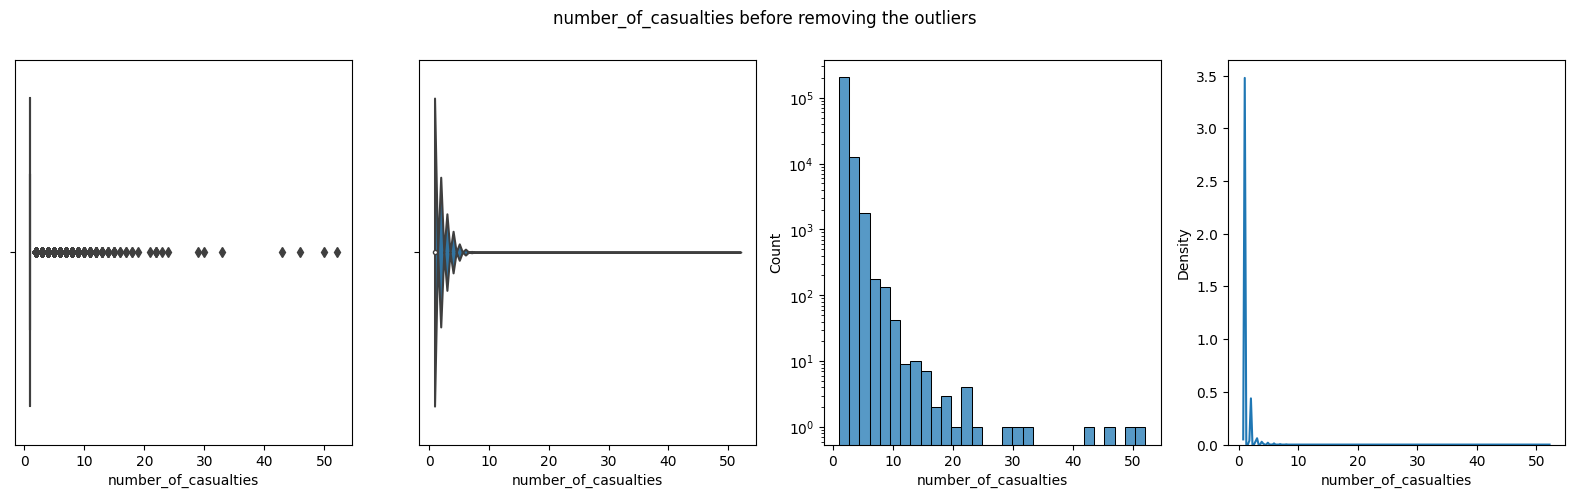

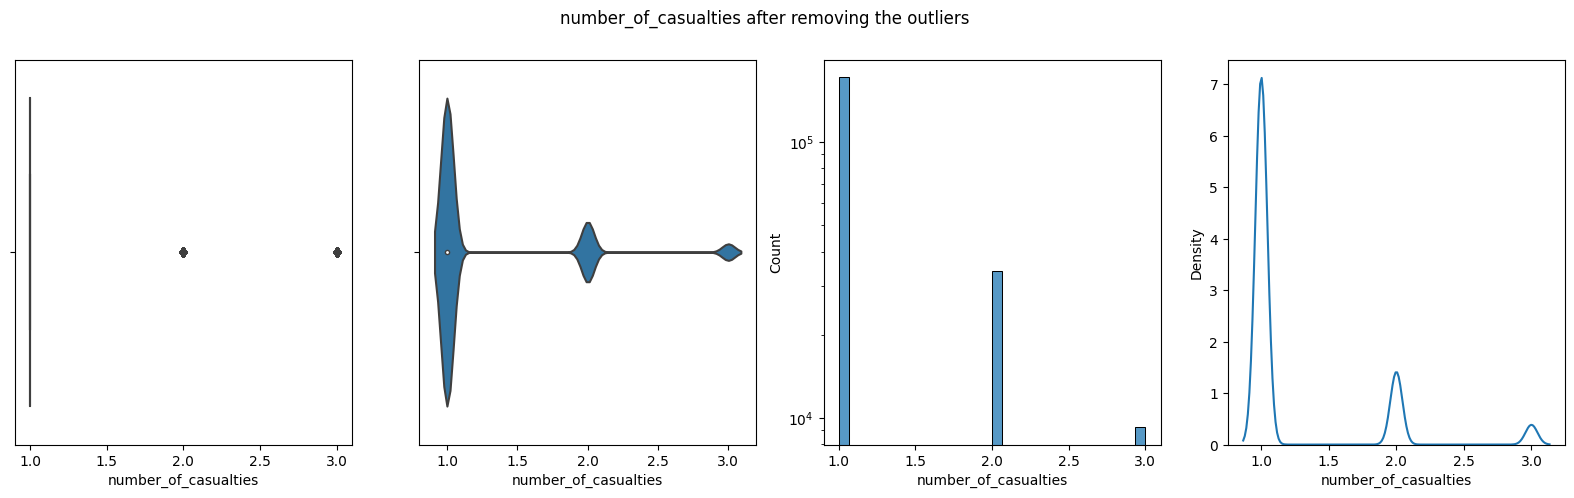

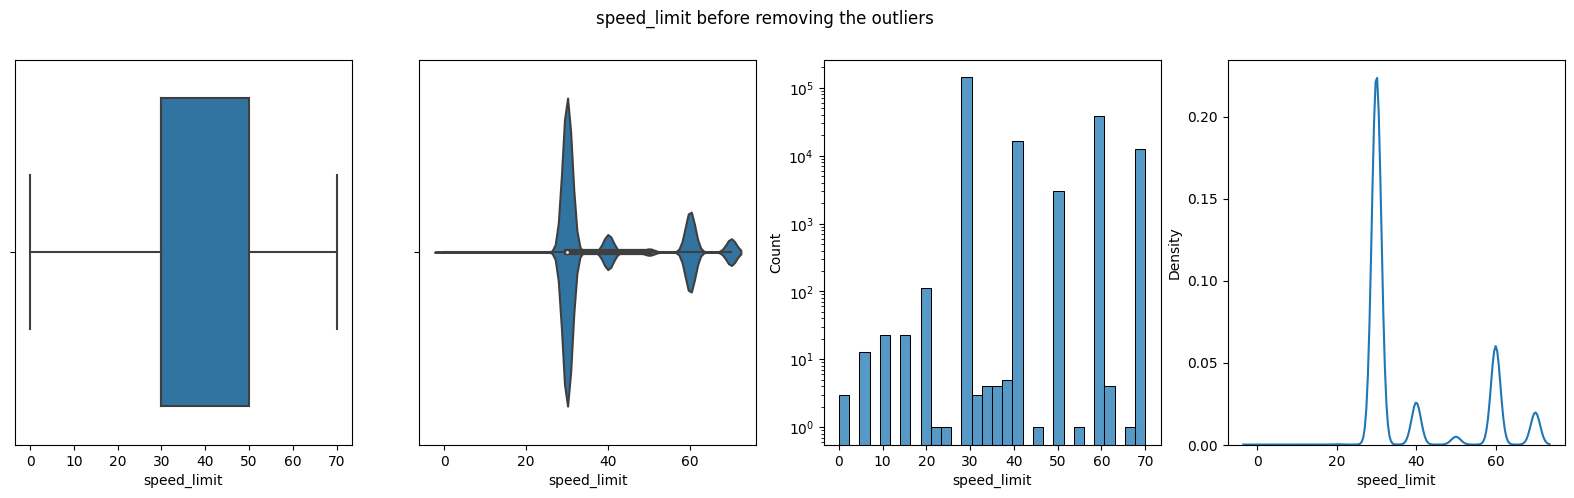

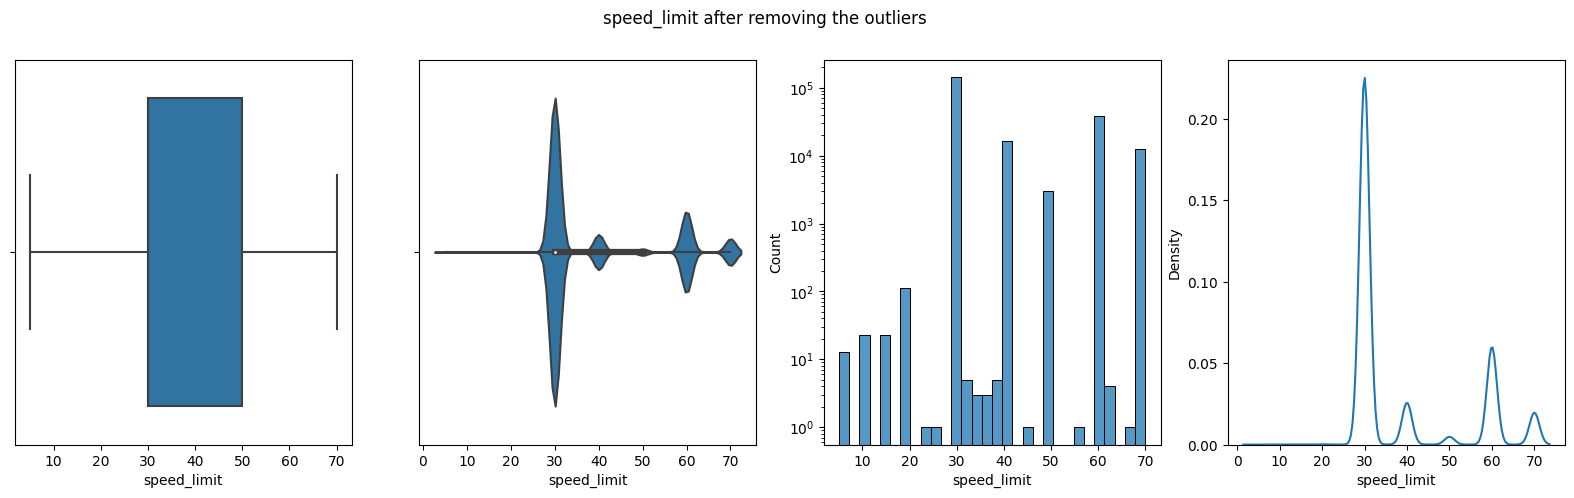

In [186]:
print("Data shape before removing the outliers",accidents_after_encoding.shape)
accidents_with_no_outliers = remove_outliers (accidents_after_encoding.copy(), numerical_columns_names)
print("Data shape after removing the outliers",accidents_with_no_outliers.shape)

## Histograms of numerical features.

In [187]:
def get_hist_numeric_col(df):
  colnames_numerics_only = df.select_dtypes(include=np.number).columns.tolist()
  colnames_numerics_only= [e for e in colnames_numerics_only if e not in ('location_easting_osgr','location_northing_osgr','longitude','latitude')]
  df_num=df[colnames_numerics_only]
  df_num.hist( bins=20, grid=False, figsize=(20,12),log=True)
  # plt.style.use('dark_background')

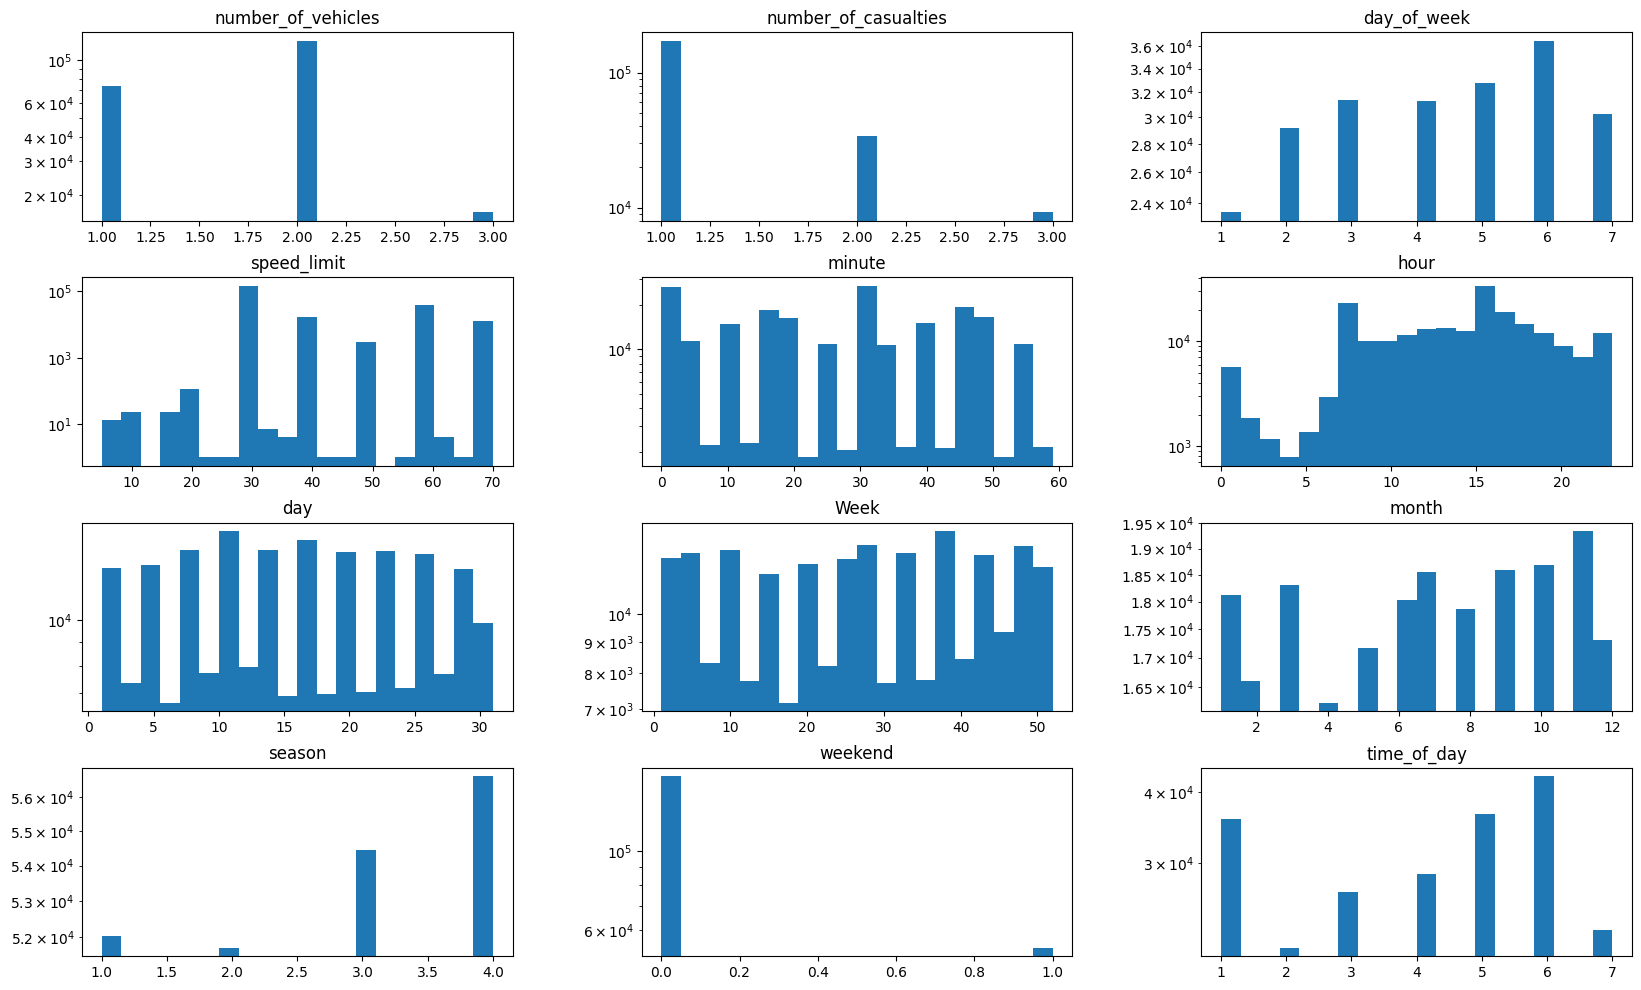

In [188]:
get_hist_numeric_col(accidents_with_no_outliers[new_numerical_columns_names])

## Scale The numerical features.

In [189]:
'''
  Scale the numerical features using the min max scaler.
  since not all the features have the same range of values for example the week
  contains values from 1 - 52 and minutes contain values from 1 - 60 while
  holiday contains only 0 and one and day_of_week have only values from 1 - 7
  so there is a need for scaling the numerical features we choose
  MinmaxScaler since the distribution is non-normal which keeps the original
  distribution of the data.
'''
def scaling (df, new_numerical_columns_names):
  df[new_numerical_columns_names] = MinMaxScaler().fit_transform(df[new_numerical_columns_names])

  return df

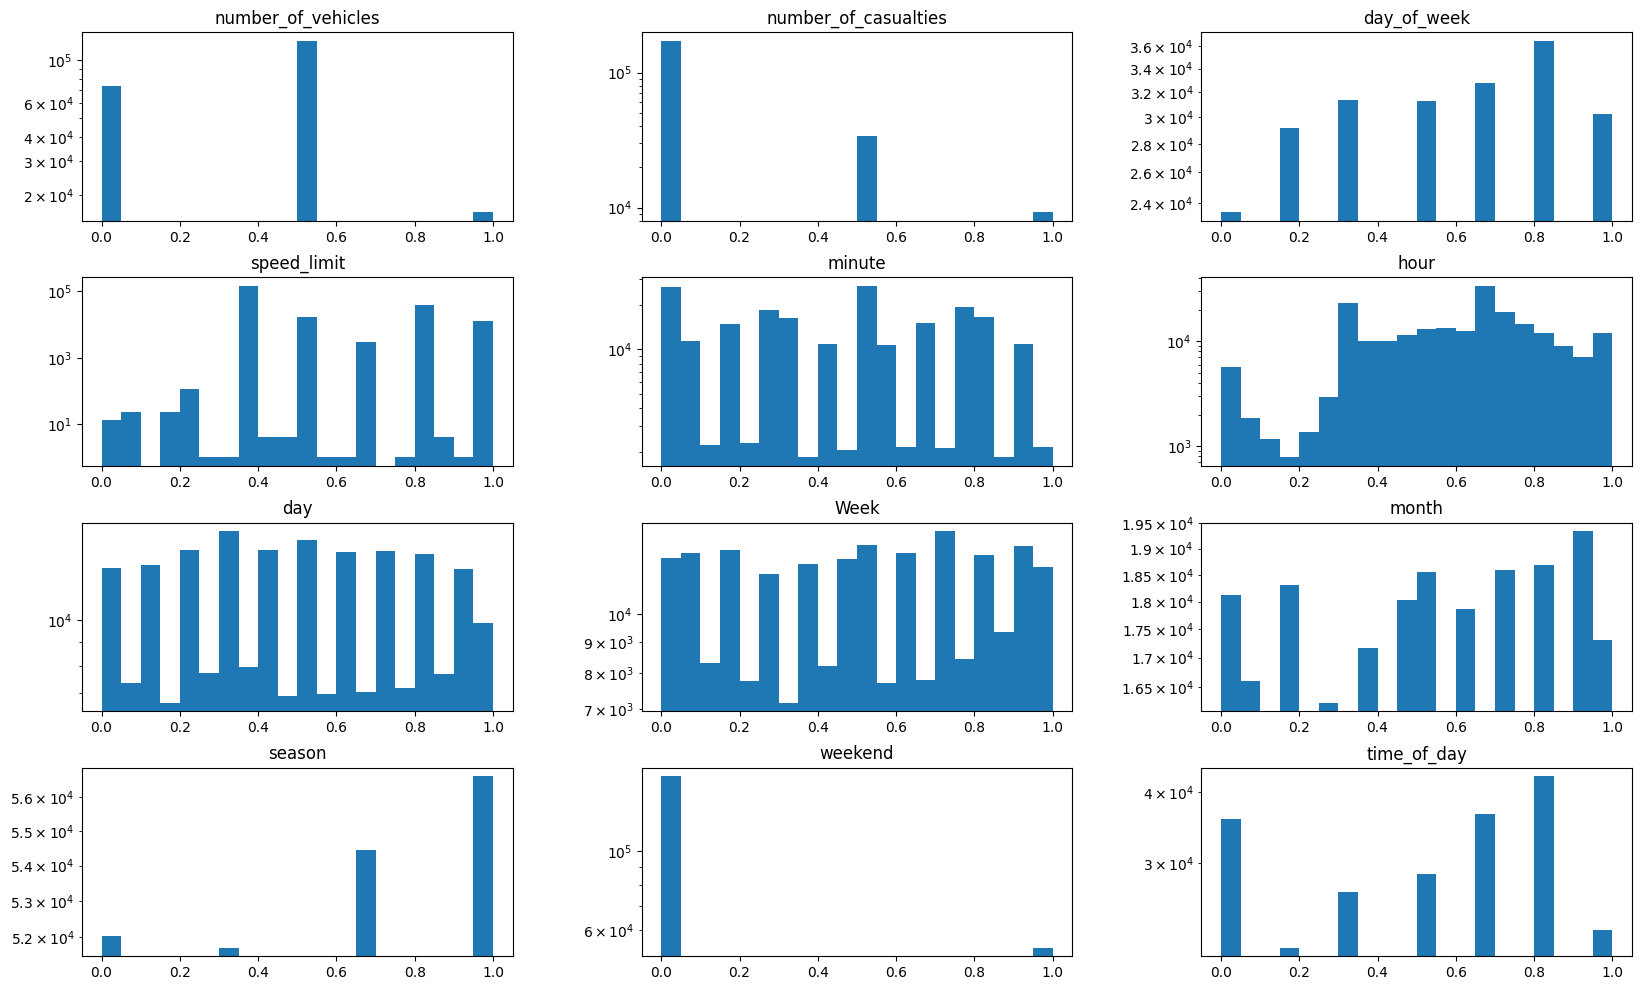

In [190]:
accidents_with_scalling = scaling(accidents_with_no_outliers.copy(), new_numerical_columns_names)
accidents_with_scalling.to_csv('normalized_df.csv')
get_hist_numeric_col(accidents_with_scalling[new_numerical_columns_names])

In [191]:
# dictionaries for calculating the day parts and seasons of year and day of week
#  encoding.
time_of_day_parts = {
    1 : "Morning Rush (6-10)",
    2 : "Day (10-12)",
    3 : "Lunch Rush (12-14)",
    4 : "Afternoon (14-16)",
    5 : "After Work Rush (16-18)",
    6 : "Evening (18-22)",
    7 : "Night (22-6)"
    }

seasons = {
    1 : "spring",
    2 : "summer",
    3 : "fall",
    4 : "winter",
    }

day_of_week = {
    "Sunday" : 1,
    "Monday" : 2,
    "Tuesday" : 3,
    "Wednesday" : 4,
    "Thursday" : 5,
    "Friday" : 6,
    "Saturday" : 7
    }

accident_severity = {
    'Fatal' : 2,
    'Serious' : 1,
    'Slight' : 0
    }

light_conditions =  {
    "Daylight": 0,
    'Daylight':1,
    "Darkness - lights lit": 1,
    "Darkness - no lighting": 2,
    "Darkness - lights unlit": 2,
    "Darkness - lighting unknown": 2,
    }

encoding_df = pd.DataFrame([],columns=["Column Name","Value","Meaning/Encoded Value"])
h= pd.DataFrame({'Value':day_of_week.keys(),'Meaning/Encoded Value':day_of_week.values()})
h["Column Name"] = "day_of_week"
# h = h.iloc[:,[2,0,1]]
encoding_df = pd.concat([encoding_df, h],axis = 0,)
h= pd.DataFrame({'Value':time_of_day_parts.keys(),'Meaning/Encoded Value':time_of_day_parts.values()})
h["Column Name"] = "time_of_day_parts"
# h = h.iloc[:,[2,0,1]]
encoding_df = pd.concat([encoding_df, h],axis = 0,)
h= pd.DataFrame({'Value':seasons.keys(),'Meaning/Encoded Value':seasons.values()})
h["Column Name"] = "seasons"
# h = h.iloc[:,[2,0,1]]
encoding_df = pd.concat([encoding_df, h],axis = 0,)
h= pd.DataFrame({'Value':accident_severity.keys(),'Meaning/Encoded Value':accident_severity.values()})
h["Column Name"] = "accident_severity"
encoding_df = pd.concat([encoding_df, h],axis = 0,)
encoding_df.to_csv("encoding_df.csv")
encoding_df

,Column Name,Value,Meaning/Encoded Value
0,day_of_week,Sunday,1
1,day_of_week,Monday,2
2,day_of_week,Tuesday,3
3,day_of_week,Wednesday,4
4,day_of_week,Thursday,5
5,day_of_week,Friday,6
6,day_of_week,Saturday,7
0,time_of_day_parts,1,Morning Rush (6-10)
1,time_of_day_parts,2,Day (10-12)
2,time_of_day_parts,3,Lunch Rush (12-14)


In [192]:
df = pd.read_csv("normalized_df.csv")
df.drop("accident_reference",axis = 1,inplace=True)

In [193]:
df.head()

,location_easting_osgr,location_northing_osgr,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,speed_limit,light_conditions,minute,hour,...,special_conditions_at_site_Roadworks,carriageway_hazards_Dog on road,carriageway_hazards_Other animal on road,carriageway_hazards_Other object on road,carriageway_hazards_Previous accident,carriageway_hazards_Vehicle load on road,urban_or_rural_area_Rural,urban_or_rural_area_Unallocated,trunk_road_flag_Data missing or out of range,trunk_road_flag_Trunk (Roads managed by Highways England)
0,0.631349,0.193322,1,0.0,0.0,1.000000,1.0,0,0.762712,0.608696,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.617324,0.195725,1,1.0,1.0,0.833333,1.0,0,0.830508,0.347826,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.621174,0.192737,0,1.0,0.0,0.833333,1.0,1,0.508475,0.782609,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.620267,0.193242,0,1.0,0.0,0.333333,1.0,1,0.593220,0.739130,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.620280,0.193242,0,0.5,0.0,0.666667,1.0,1,0.169492,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [194]:
correlation_scores = df.drop('accident_severity', axis=1).corrwith(df['accident_severity'])
sorted_scores = correlation_scores.abs().sort_values(ascending=False)
top_features = sorted_scores[sorted_scores > 0.015].index
top_scores = correlation_scores.loc[top_features]
faetures = top_scores.index.tolist()
faetures.append("accident_severity")
df = df[faetures]


In [195]:
df.head()

,number_of_vehicles,number_of_casualties,speed_limit,second_road_class_Not at junction or within 20 metres,junction_control_Not at junction or within 20 metres,urban_or_rural_area_Rural,light_conditions,junction_detail_Roundabout,time_of_day,road_type_Roundabout,...,weekend,junction_detail_Crossroads,local_authority_ons_district_Manchester,police_force_Lancashire,road_type_One way street/Slip road,location_easting_osgr,junction_detail_Other junction,local_authority_ons_district_Liverpool,police_force_Cheshire,accident_severity
0,0.0,0.0,1.0,1.0,1.0,1.0,0,0.0,0.500000,0.0,...,1.0,0.0,0,0,0.0,0.631349,0.0,0,0,1
1,1.0,1.0,1.0,1.0,1.0,1.0,0,0.0,0.000000,0.0,...,0.0,0.0,0,0,0.0,0.617324,0.0,0,0,1
2,1.0,0.0,1.0,1.0,1.0,1.0,1,0.0,0.833333,0.0,...,0.0,0.0,0,0,0.0,0.621174,0.0,0,0,0
3,1.0,0.0,1.0,1.0,1.0,1.0,1,0.0,0.666667,0.0,...,0.0,0.0,0,0,0.0,0.620267,0.0,0,0,0
4,0.5,0.0,1.0,1.0,1.0,1.0,1,0.0,1.000000,0.0,...,0.0,0.0,0,0,0.0,0.620280,0.0,0,0,0


In [196]:
def evaluate(X, Y):
    # Evaluate the model
    y_pred = model.predict(X)

    # Confusion matrix
    confusion_mat = confusion_matrix(Y, y_pred)
    # Heatmap
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Accuracy, Precision, Recall, F1-score
    accuracy = accuracy_score(Y, y_pred)
    precision = precision_score(Y, y_pred, average='macro')
    recall = recall_score(Y, y_pred, average='macro')
    f1 = f1_score(Y, y_pred, average='macro')

    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Precision: {:.2f}".format(precision * 100))
    print("Recall: {:.2f}".format(recall * 100))
    print("F1-Score: {:.2f}".format(f1 * 100))

In [197]:
# Separate the features and the target variable
X = df.drop('accident_severity', axis=1)  # Replace 'target_variable' with the actual name of your target variable
y = df['accident_severity']

# Split the dataset into training, testing, and cross-validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



# **Logistic Regression**

The best Parameters are : {'C': 0.01, 'penalty': 'l2'}
Cross-Validation Evaluation:


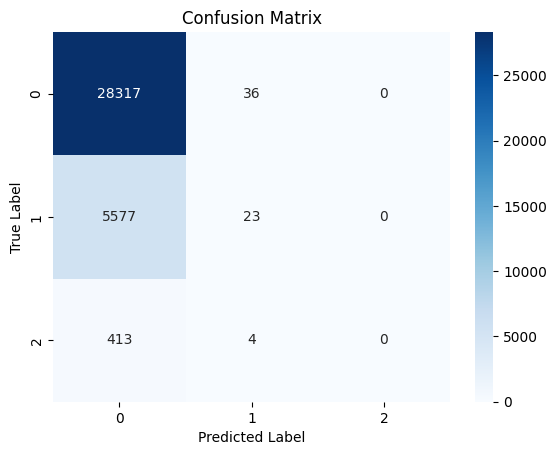

Accuracy: 82.46%
Precision: 39.68
Recall: 33.43
F1-Score: 30.40
Test Set Evaluation:


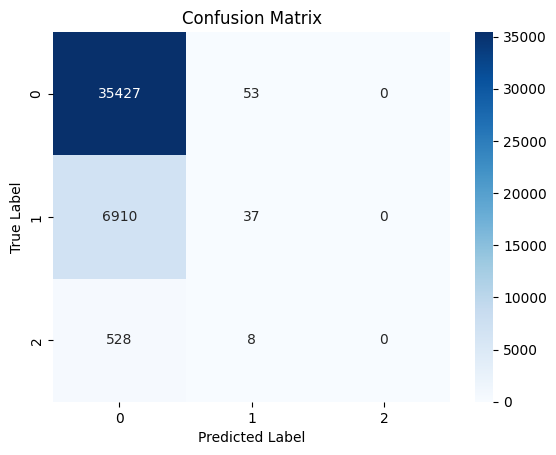

Accuracy: 82.55%
Precision: 40.13
Recall: 33.46
F1-Score: 30.50


In [198]:
# Initialize the logistic regression model
model = LogisticRegression()

# Define the hyperparameter grid for fine-tuning
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  # regularization strength
    'penalty': ['l1', 'l2'],  # regularization type
}
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
model = grid_search.best_estimator_
print("The best Parameters are :",grid_search.best_params_)

# Evaluate the model on the cross-validation set
print("Cross-Validation Evaluation:")
evaluate(X_cv, y_cv)

# Evaluate the model on the test set
print("Test Set Evaluation:")
evaluate(X_test, y_test)


# **KNN**

The best Parameters are : {'n_neighbors': 7, 'weights': 'uniform'}
Cross-Validation Evaluation:


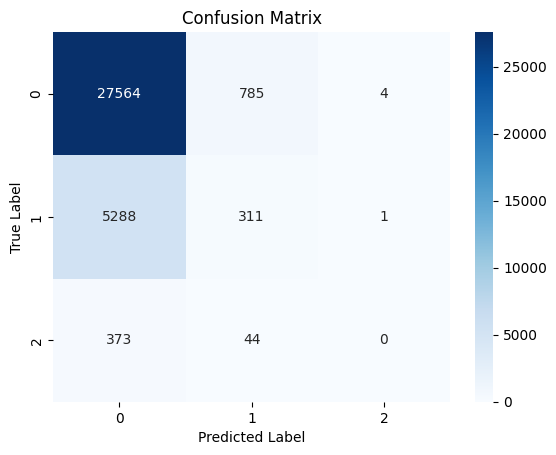

Accuracy: 81.10%
Precision: 36.75
Recall: 34.26
F1-Score: 32.92
Test Set Evaluation:


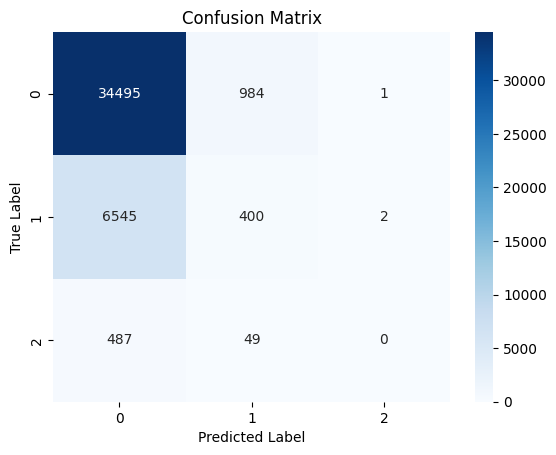

Accuracy: 81.22%
Precision: 36.99
Recall: 34.33
F1-Score: 33.05


In [199]:
# Initialize the KNN model
model = KNeighborsClassifier()

# Define the hyperparameter grid for fine-tuning
param_grid = {
    'n_neighbors': [3, 5, 7],  # number of neighbors
    'weights': ['uniform', 'distance'],  # weight function
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
model = grid_search.best_estimator_
print("The best Parameters are :",grid_search.best_params_)

# Evaluate the model on the cross-validation set
print("Cross-Validation Evaluation:")
evaluate(X_cv, y_cv)

# Evaluate the model on the test set
print("Test Set Evaluation:")
evaluate(X_test, y_test)

# **Naive Bayes**

The best Parameters are : {'var_smoothing': 0.5}
Cross-Validation Evaluation:


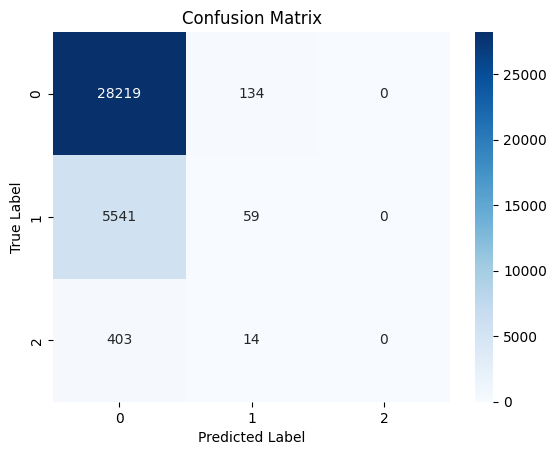

Accuracy: 82.28%
Precision: 37.03
Recall: 33.53
F1-Score: 30.77
Test Set Evaluation:


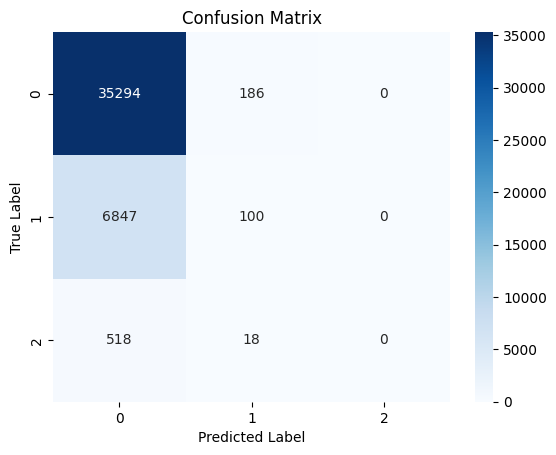

Accuracy: 82.38%
Precision: 38.54
Recall: 33.64
F1-Score: 31.03


In [200]:
# Initialize the Naive Bayes model
model = GaussianNB()

# Define the hyperparameter grid for fine-tuning
param_grid = {
    'var_smoothing': [1e-1, 5e-1, 2.5e-1]  # Variation smoothing parameter
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
model = grid_search.best_estimator_

print("The best Parameters are :",grid_search.best_params_)


# Evaluate the model on the cross-validation set
print("Cross-Validation Evaluation:")
evaluate(X_cv, y_cv)

# Evaluate the model on the test set
print("Test Set Evaluation:")
evaluate(X_test, y_test)


# **Neural Network**

The best Parameters are : {'activation': 'relu', 'hidden_layer_sizes': (5, 10), 'learning_rate_init': 0.001}
Cross-Validation Evaluation:


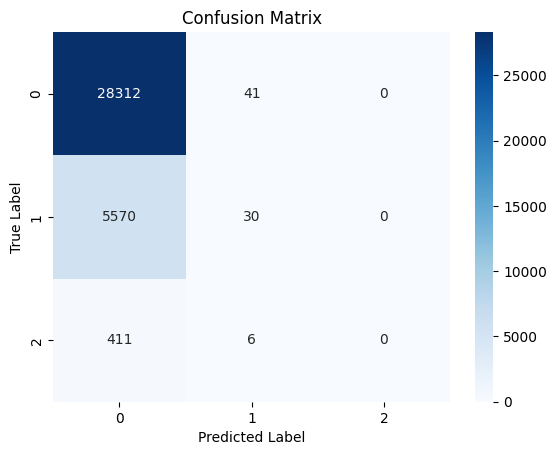

Accuracy: 82.46%
Precision: 40.51
Recall: 33.46
F1-Score: 30.48
Test Set Evaluation:


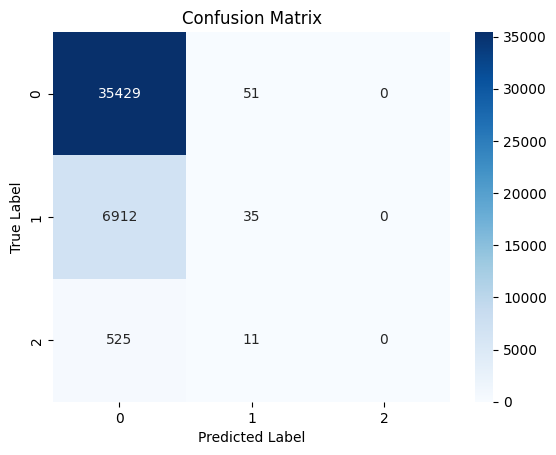

Accuracy: 82.55%
Precision: 39.58
Recall: 33.45
F1-Score: 30.48


In [201]:
# Step 1: Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [ (5, 10), (10, 10) ],
    'activation': ['relu'],
    'learning_rate_init': [ 0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Get the best model
model = grid_search.best_estimator_

print("The best Parameters are :",grid_search.best_params_)


# Evaluate the model on the cross-validation set
print("Cross-Validation Evaluation:")
evaluate(X_cv, y_cv)

# Evaluate the model on the test set
print("Test Set Evaluation:")
evaluate(X_test, y_test)

In [206]:
df["accident_severity"].value_counts(normalize = True)*100

0    82.455740
1    16.286875
2     1.257384
Name: accident_severity, dtype: float64

### **In conclusion, our analysis using K-Nearest Neighbors (KNN), Logistic Regression, and Naive Bayes algorithms has shown high accuracy but low recall and precision. This can be attributed to the class imbalance present in our dataset. Specifically, we have encountered a significant disparity in the occurrence of different output classes.**

## **The "accident_severity" feature, particularly the "fatal" class, represents only 1% of the dataset, while the "slight" class accounts for approximately 82% of the data. This imbalance poses a challenge when attempting to apply any over or under-sampling techniques.**

## **Over-sampling involves duplicating or synthesizing data points from the minority class to balance the dataset, while under-sampling reduces the number of majority class samples. However, due to the scarcity of "fatal" accidents in our dataset, over-sampling the "fatal" class would result in an artificial increase in its representation, which could lead to misleading results. Similarly, under-sampling the majority class ("slight" accidents) would result in a significant loss of valuable information.**

## **Therefore, the class imbalance of our data presents a limitation in terms of applying traditional over or under-sampling techniques. We must address this issue carefully to avoid distorting the actual patterns and relationships in the dataset.**

## **To overcome this challenge, alternative approaches may be considered. One potential solution is to explore advanced techniques specifically designed for imbalanced datasets, such as cost-sensitive learning, anomaly detection, or using different evaluation metrics that are more robust to class imbalance, such as F1-score or area under the precision-recall curve.**

## **Additionally, collecting more data on "fatal" accidents would be highly beneficial for improving the performance of our models. By increasing the representation of the minority class, we can create a more balanced dataset, allowing for better generalization and more accurate predictions.**